<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/yeast_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# アノテーションサービスを活用した酵母細胞検出モデルの訓練

## 解説
機械学習モデルを訓練するためには、使用するモデルに応じて異なる形式でアノテーション付きデータセットが必要となることが多いです。しかし、データセットをモデルが要求する特定のフォーマットに変換するためのコードを一から作成する作業は、非常に手間がかかります。オンラインのデータアノテーションサービスを利用することで、必要なフォーマットのデータセットを簡単に入手できます。このノートブックでは、Roboflowによって公開されたアノテーション済みデータセットを、YOLOv8が利用可能な形式で直接ダウンロードし、酵母細胞の数を計算するモデルを構築する方法について紹介します。

## ライセンス
- 酵母生死細胞検出データセット
    - データセット作成者："AIML Cell Yeast Counter"
    - CC-BY-4.0
    - https://universe.roboflow.com/aiml-cell-yeast-counter/yeast-deadcell
- 本ノートブック
    - CC-BY-NC-4.0
    
## 注意事項
本ノートブックで使用するデータセットは、第三者によって善意で公開されているものであり、データの出自や品質についての保証はありません。使用する際は、利用者自身の責任において適切に取り扱ってください。データセットの内容について、不明な点や懸念がある場合は、データセットの提供者に直接連絡を取ることをお勧めします。また、データセットの使用に際しては、ライセンスを確認し、その条件に従ってください。

## 環境設定

In [1]:
!pip install -qq roboflow pip ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [40]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from roboflow import Roboflow

from IPython.display import display, Image

## データセットのダウンロード

Roboflowに登録されている公開データセットをダウンロードするためには、Roboflowへのアカウント登録と、APIキーの取得が必要となります。
- Roboflow
    - https://roboflow.com/
- APIキー取得方法
    - https://docs.roboflow.com/api-reference/authentication

**APIキーは公開モデル取得のために使われるだけでなく、個人アカウントのデータやモデルへのアクセスをコントロールするパスワードのようなものです。第三者に共有しないよう取り扱いに注意してください。**

APIキーを取得したら、下のコードセルのxxxxxx部分と置き換えて下さい。

In [3]:
# 自身のAPIキーと置き換える。
API_KEY = "MTA9yBatzCZ0LzbHxVSv"

In [4]:
rf = Roboflow(api_key=API_KEY)
project = rf.workspace("aiml-cell-yeast-counter").project("yeast-deadcell")
version = project.version(19)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.29, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to yeast-deadcell-19 in yolov8:: 100%|██████████| 240/240 [00:00<00:00, 6781.64it/s]


## データセットの確認

## YOLOv8モデルの訓練

yolov8はデフォルトでdatasetディレクトリにデータセットがあることが想定されます。Google Colaboratoryで訓練するため、フォルダ作成や、設定ファイルの移動を行います。他のデータセットにおける配置は、適宜data.yaml中身を確認してください。

In [10]:
!mkdir datasets
!mv yeast-deadcell-19 datasets/yeast-deadcell-19
!cp datasets/yeast-deadcell-19/data.yaml ./

In [11]:
!yolo task=detect mode=train \
    model=yolov8s.pt imgsz=640 \
        data=data.yaml epochs=50 \
            batch=4

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

訓練結果はruns/detect/trainフォルダに格納されています。必要に応じ、trainのフォルダごと保存しておきましょう。

val_batch0_labels.jpg


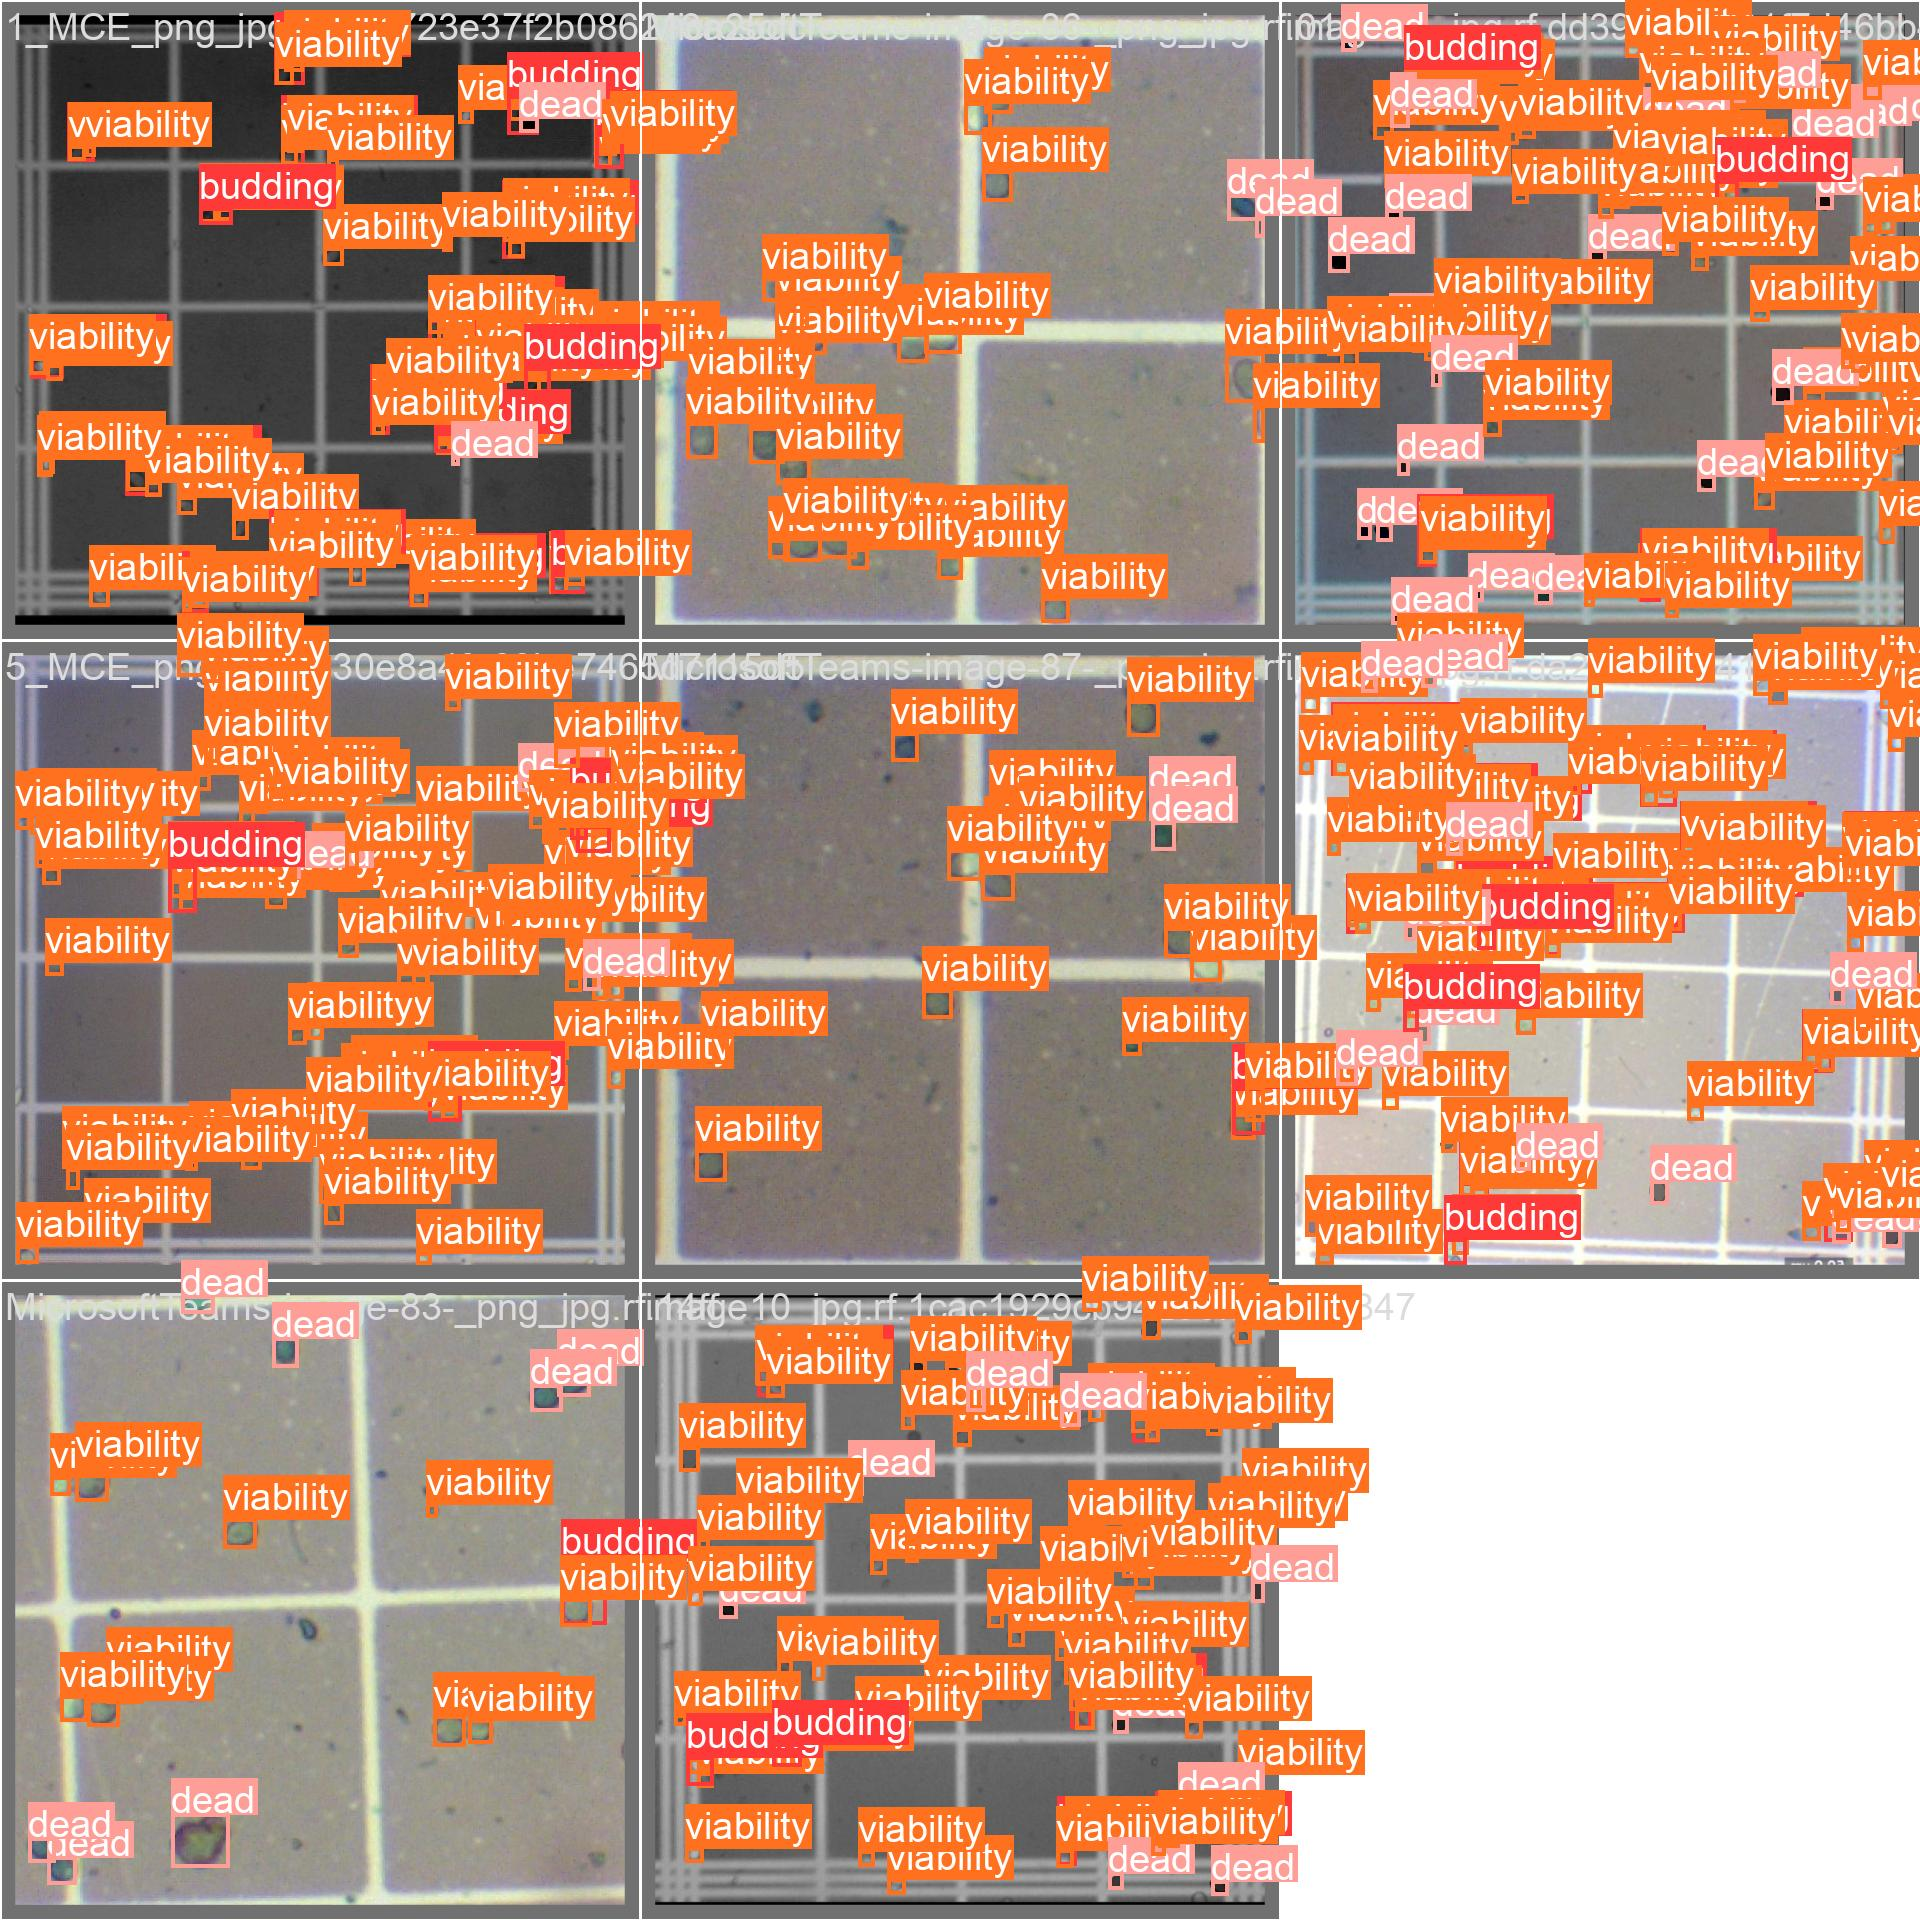

F1_curve.png


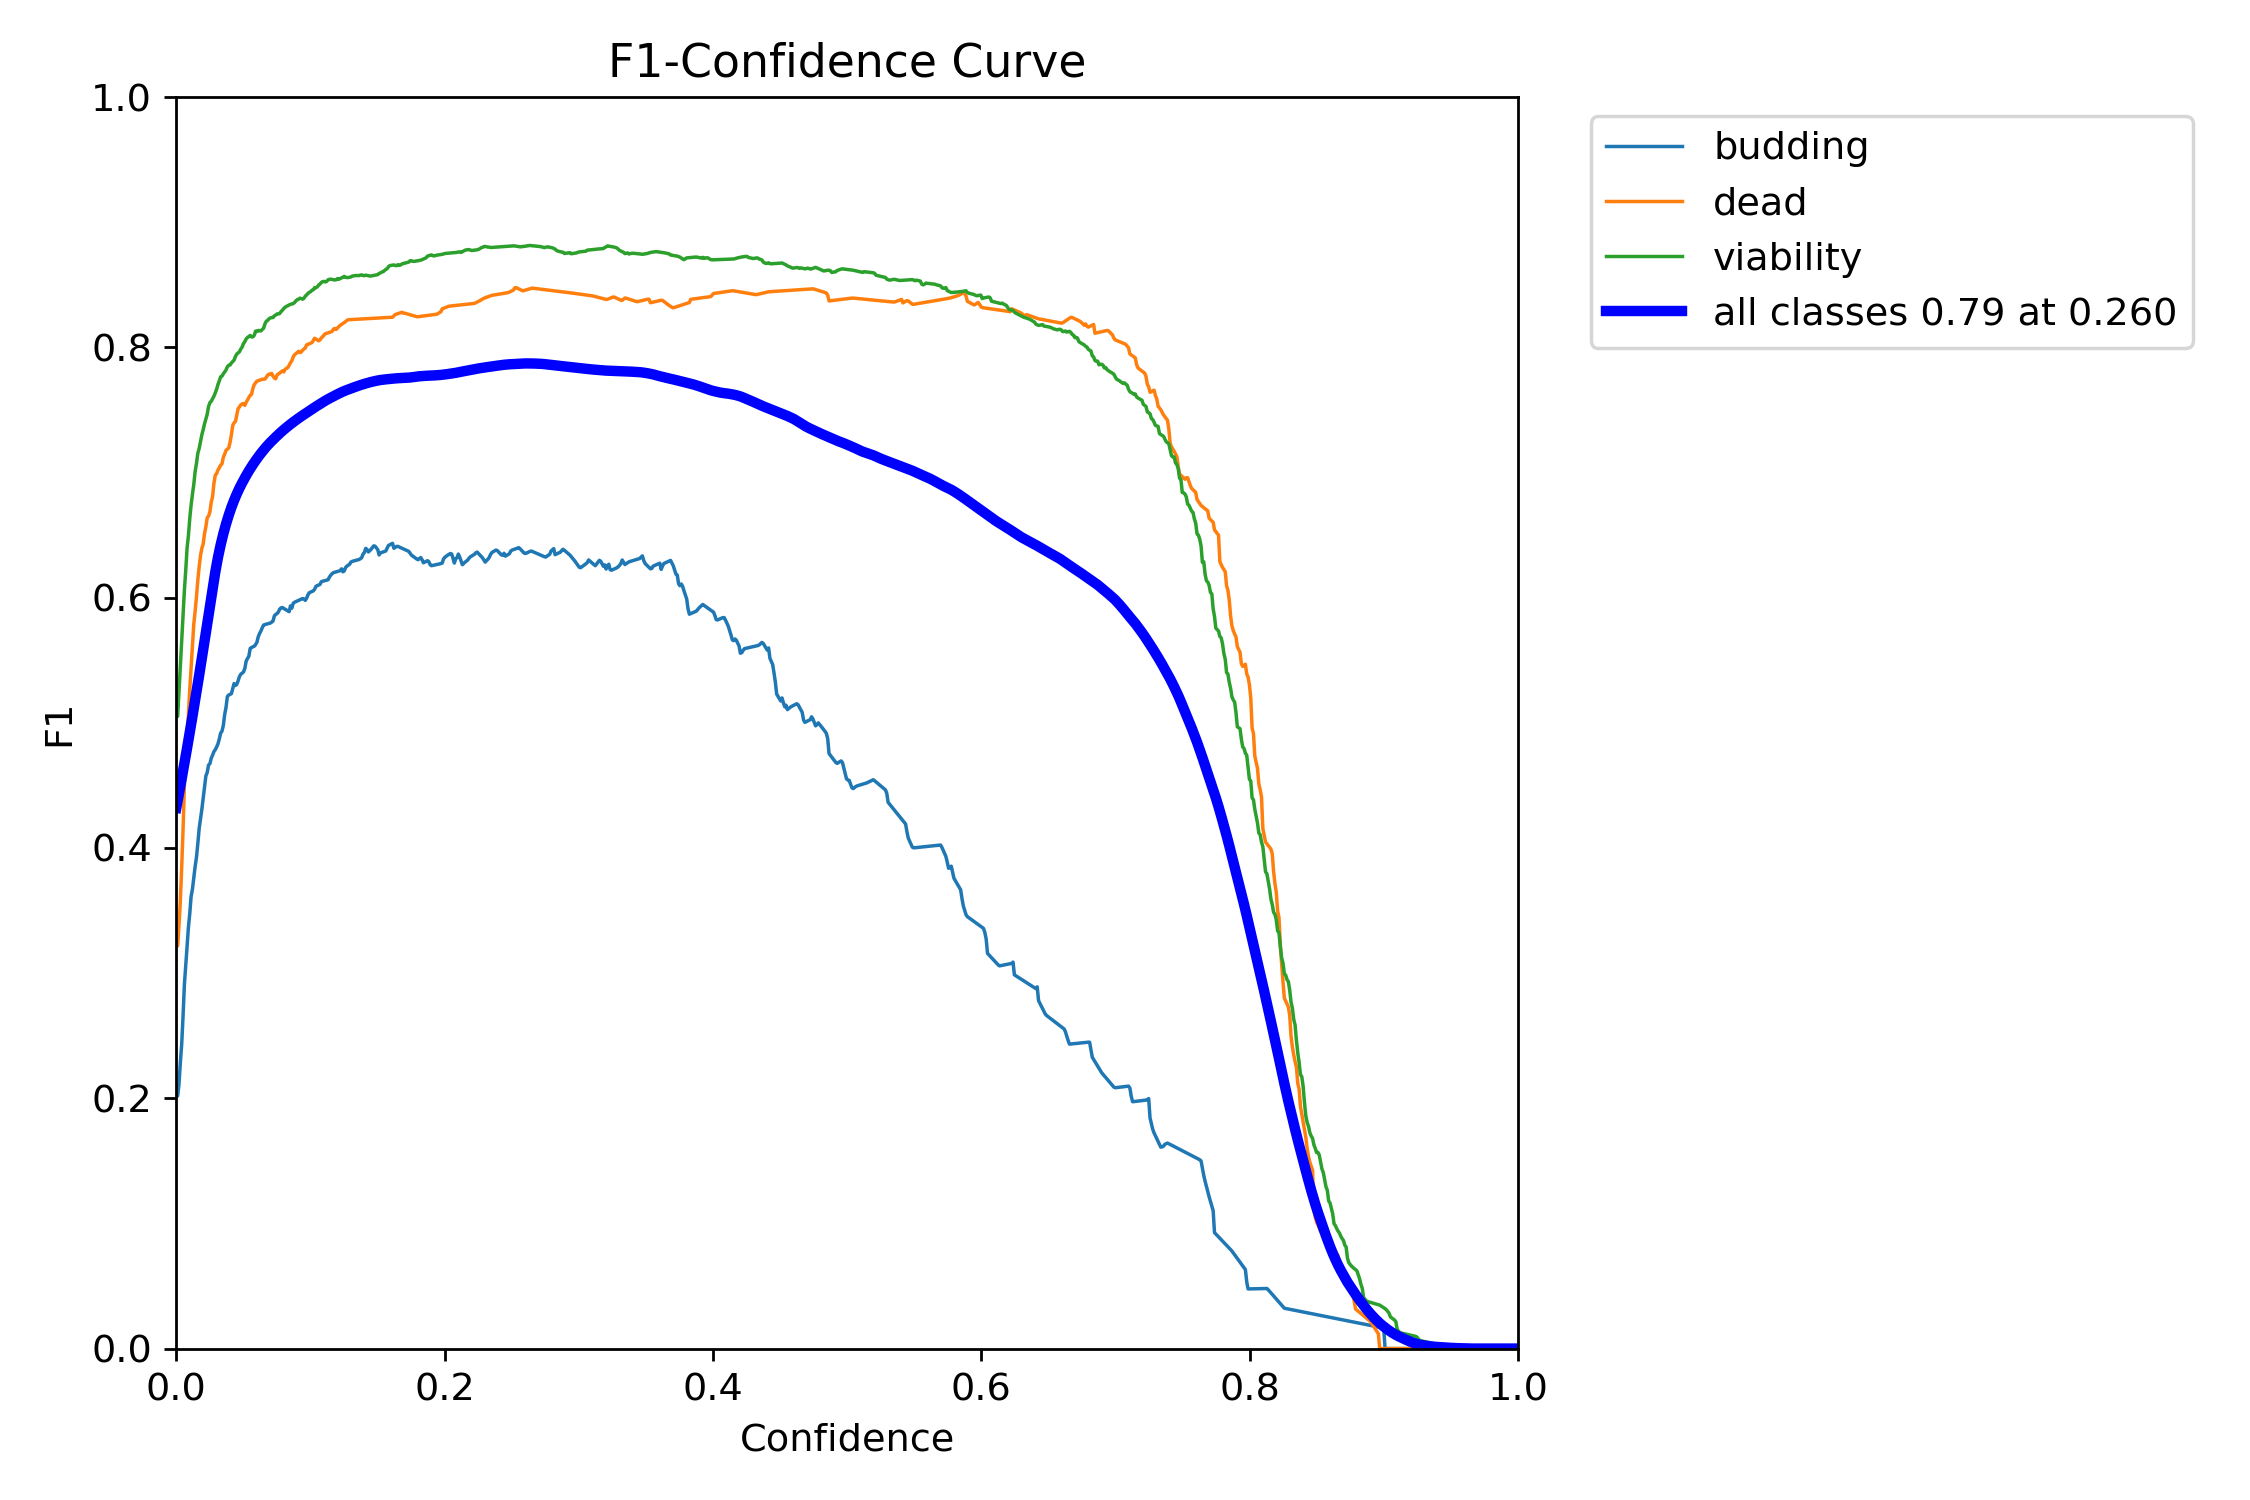

val_batch1_pred.jpg


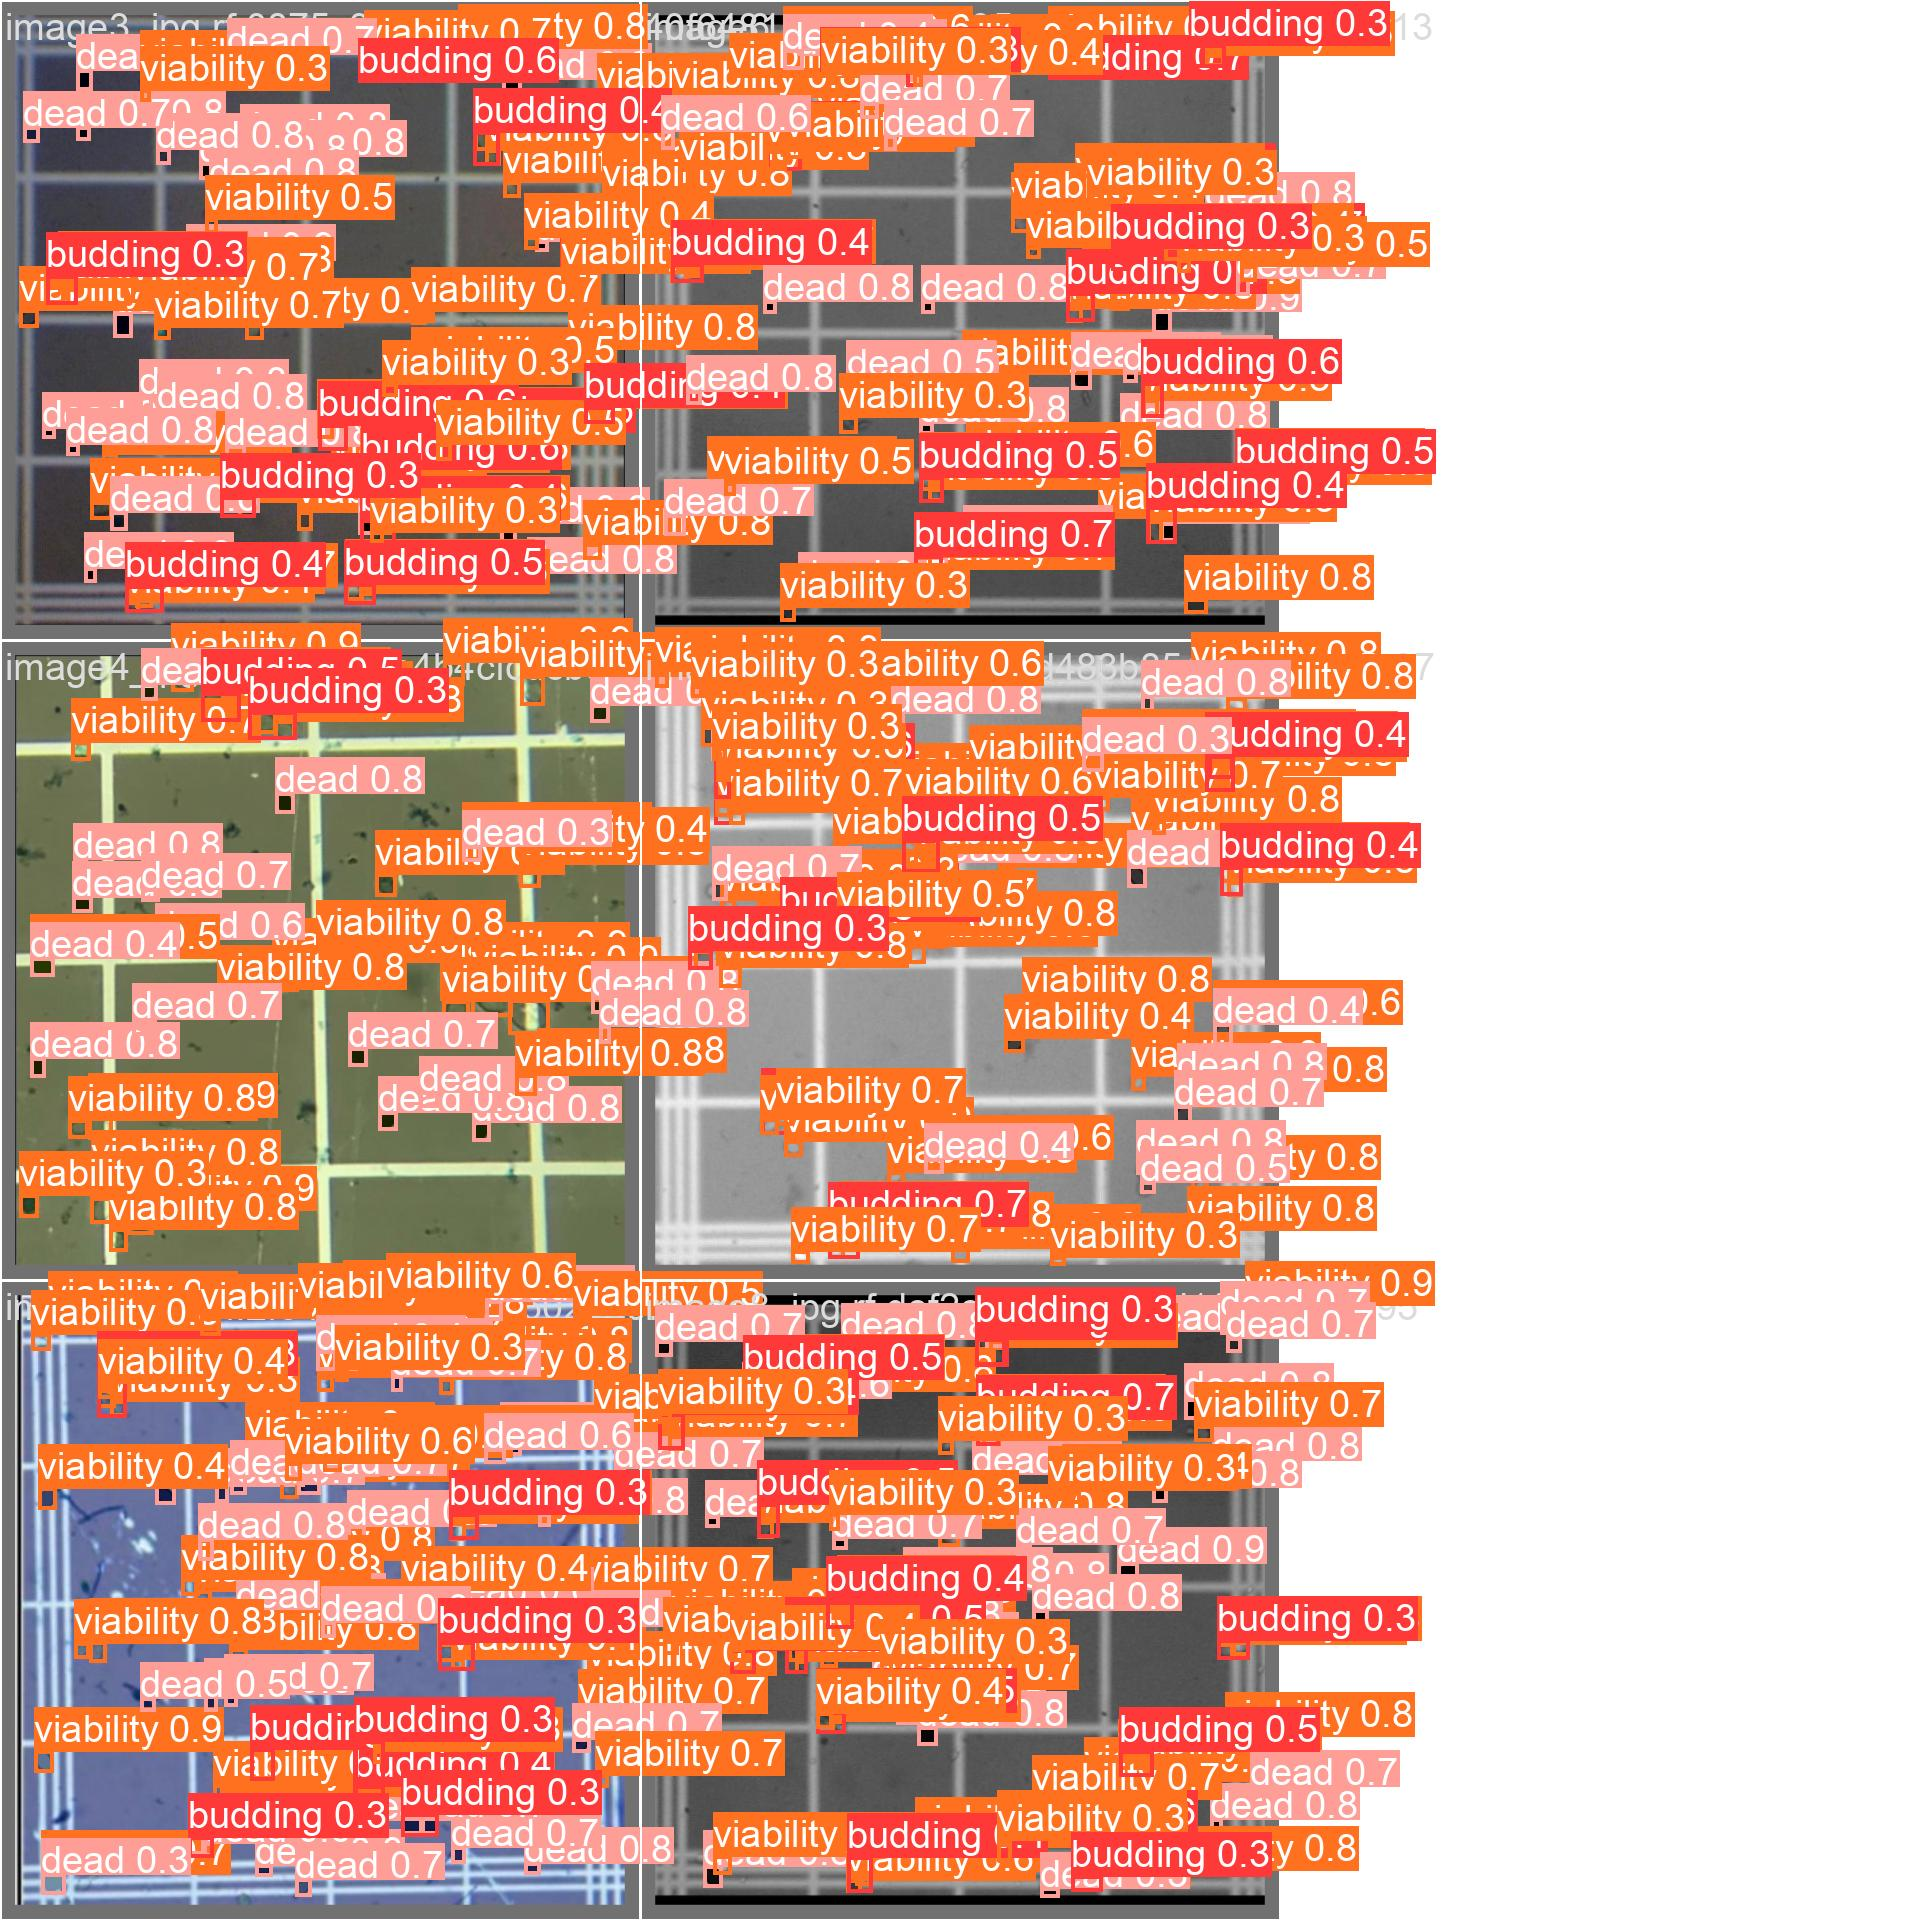

val_batch0_pred.jpg


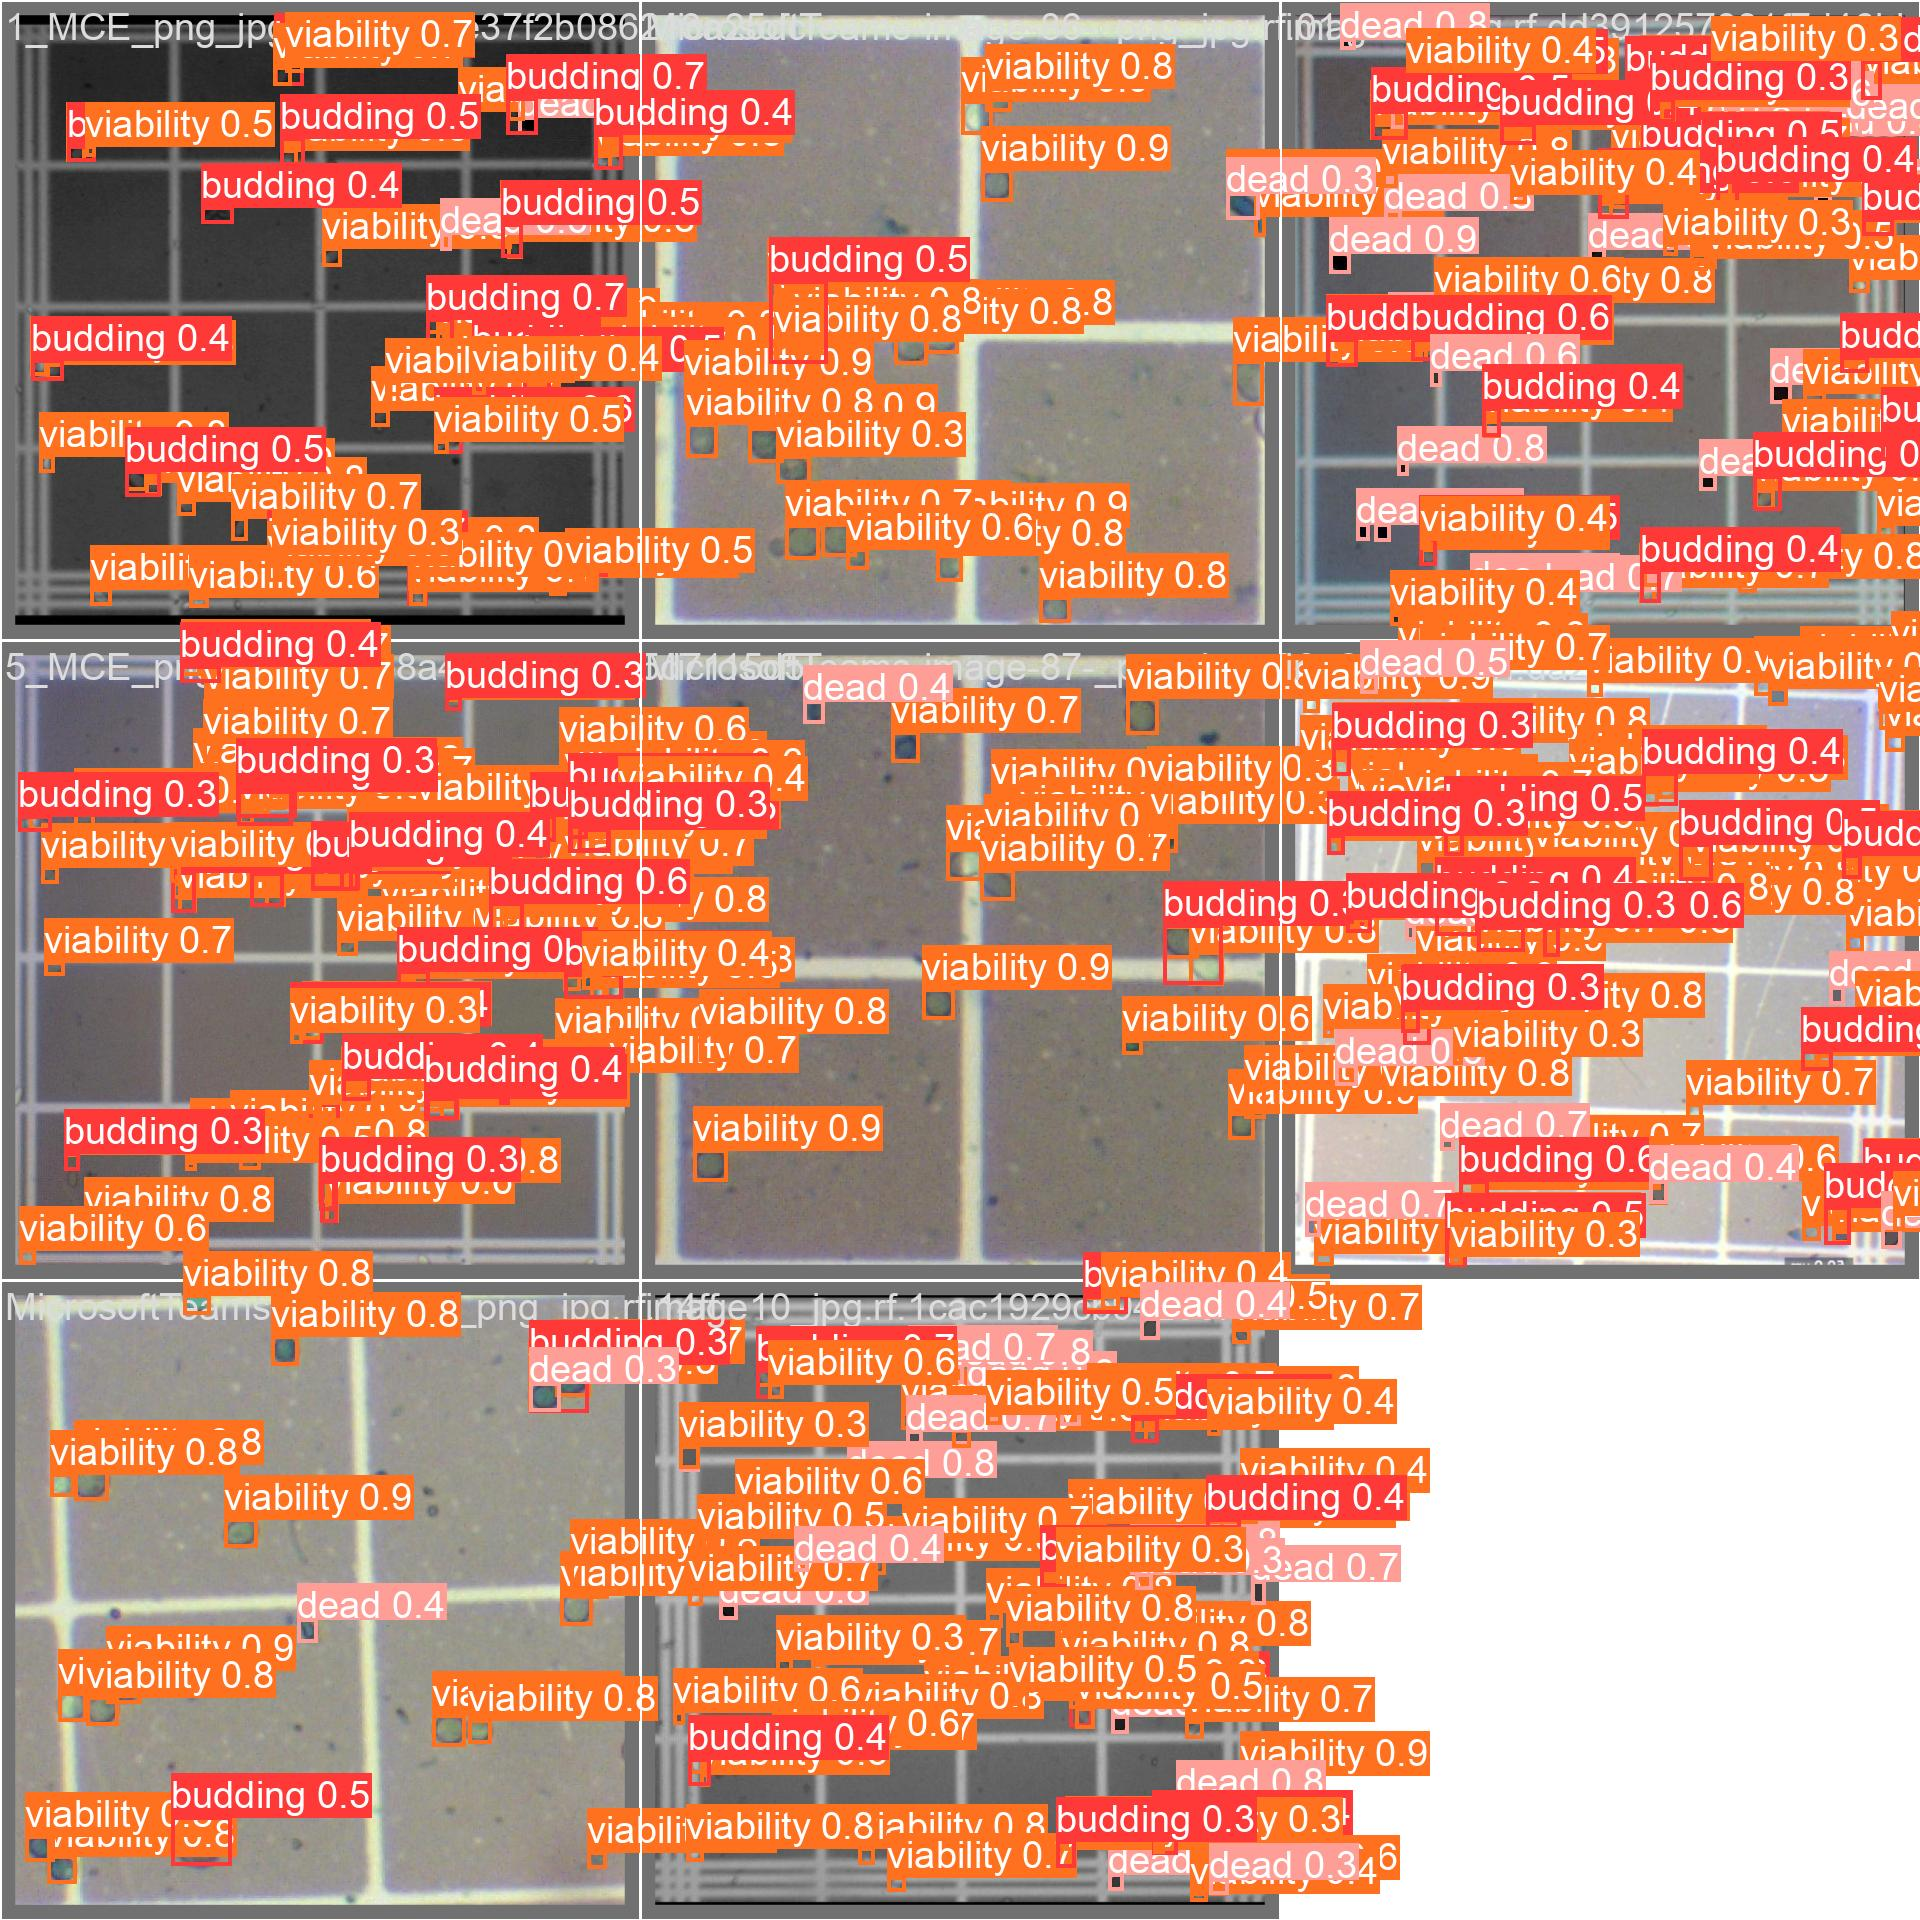

train_batch0.jpg


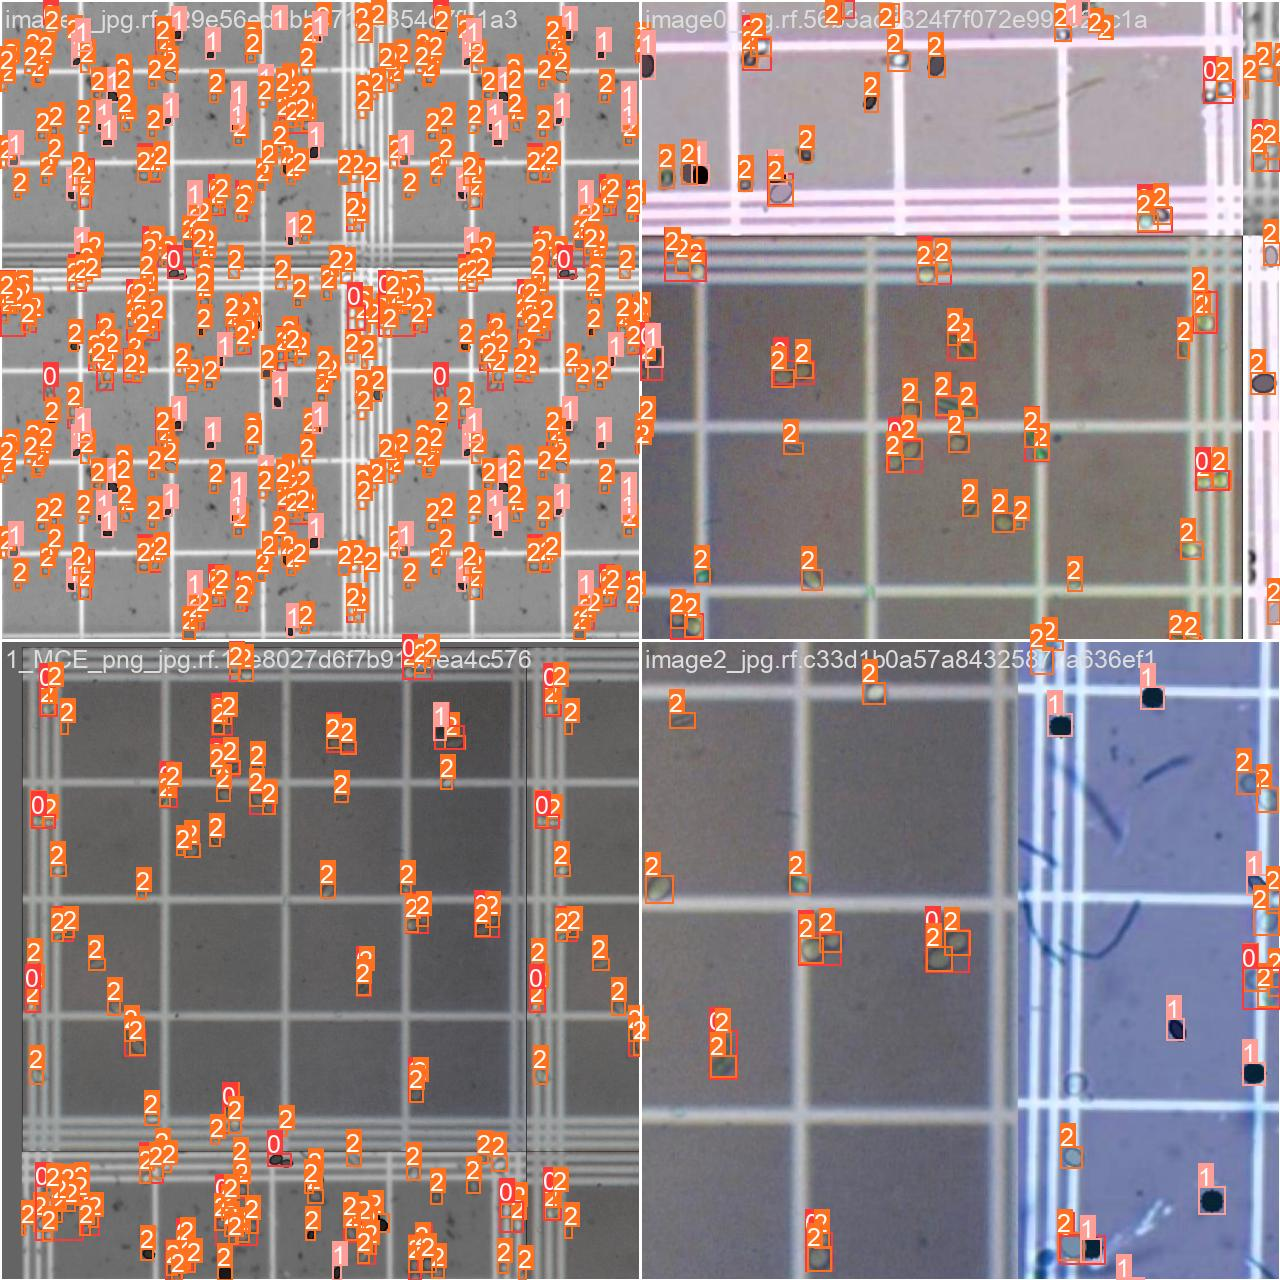

train_batch920.jpg


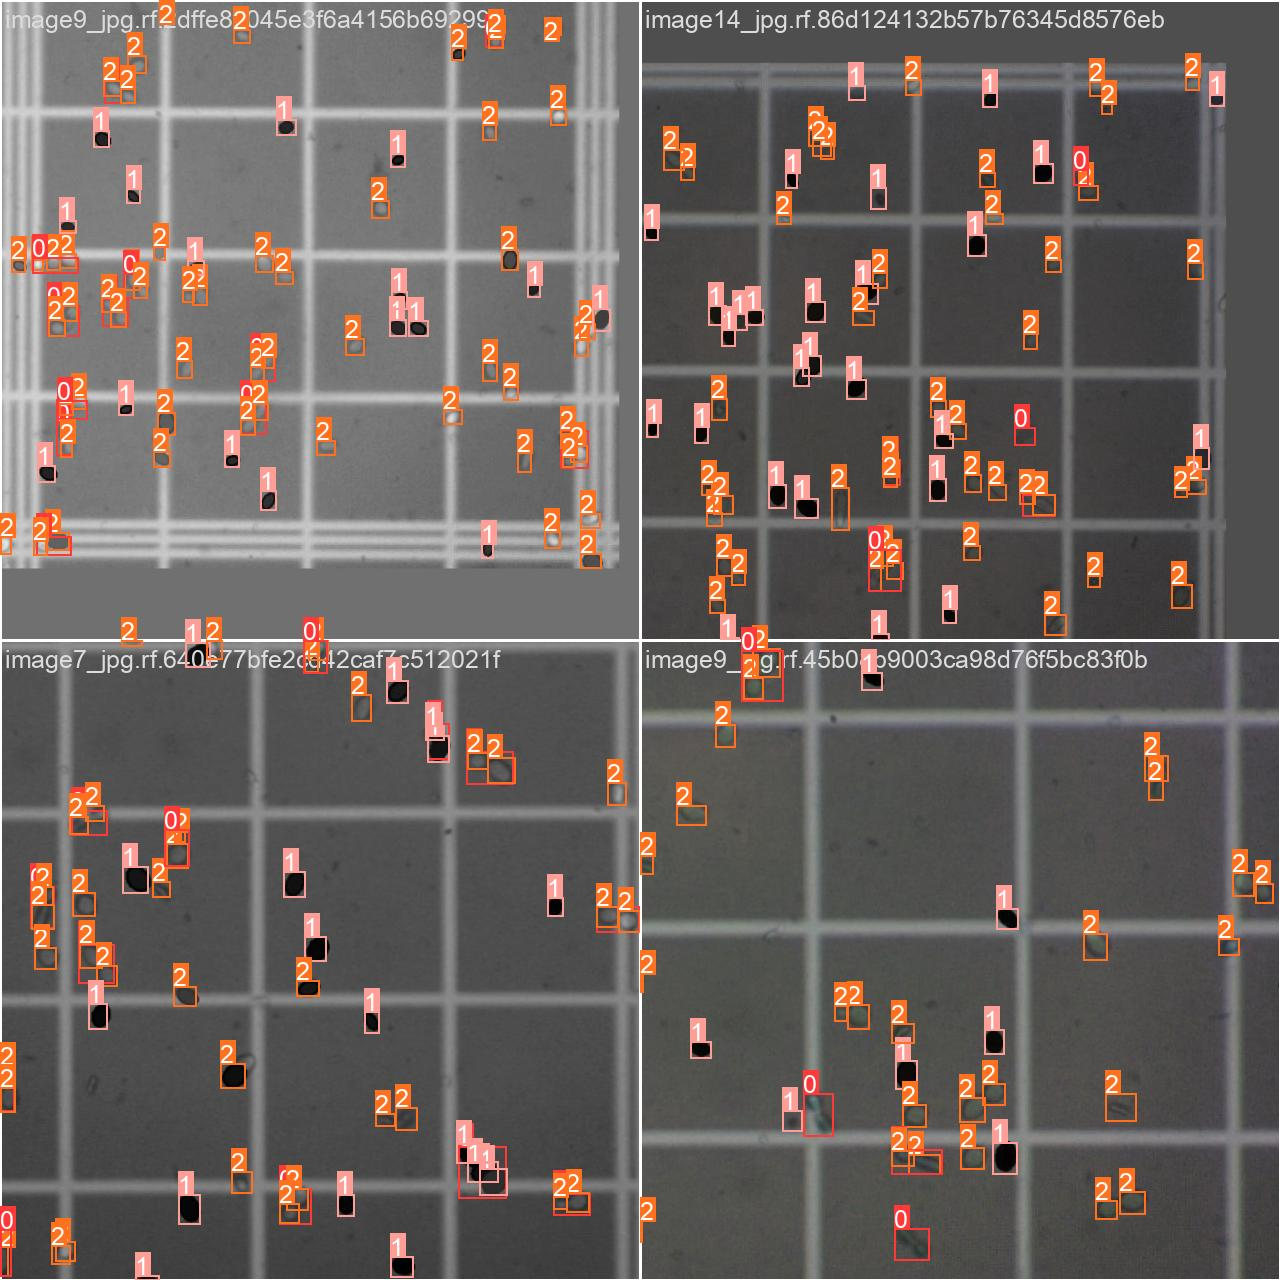

confusion_matrix.png


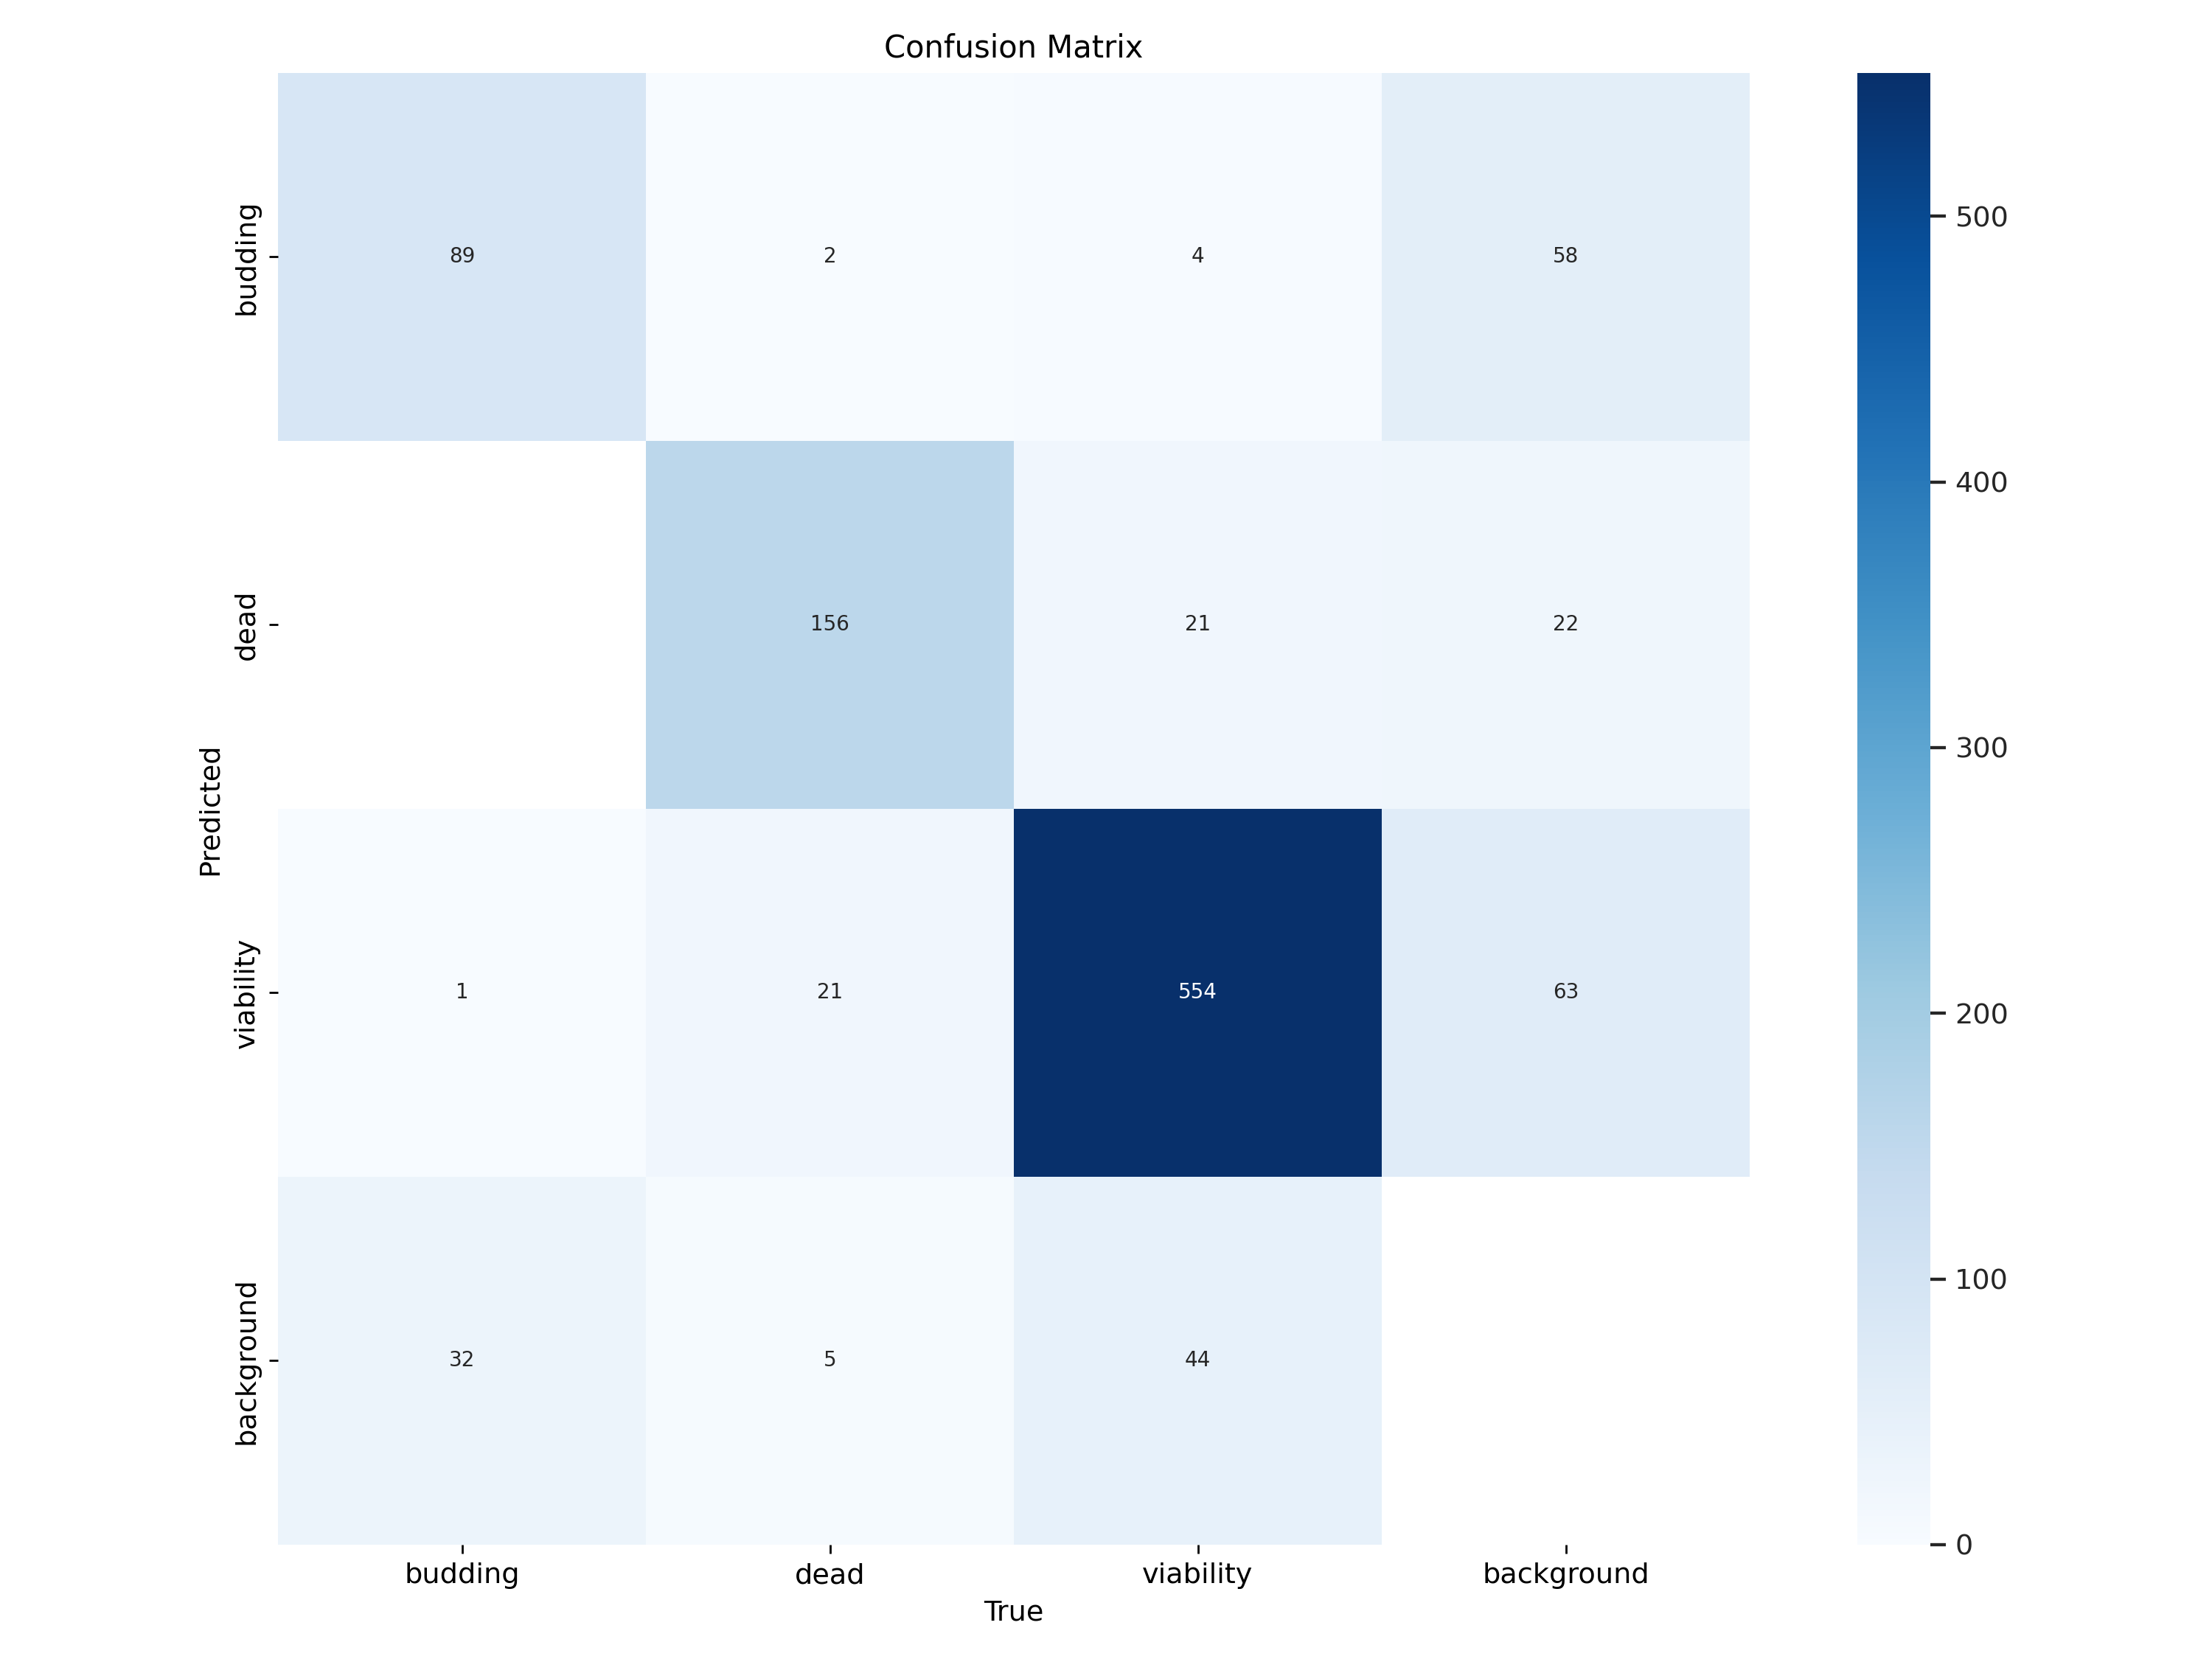

R_curve.png


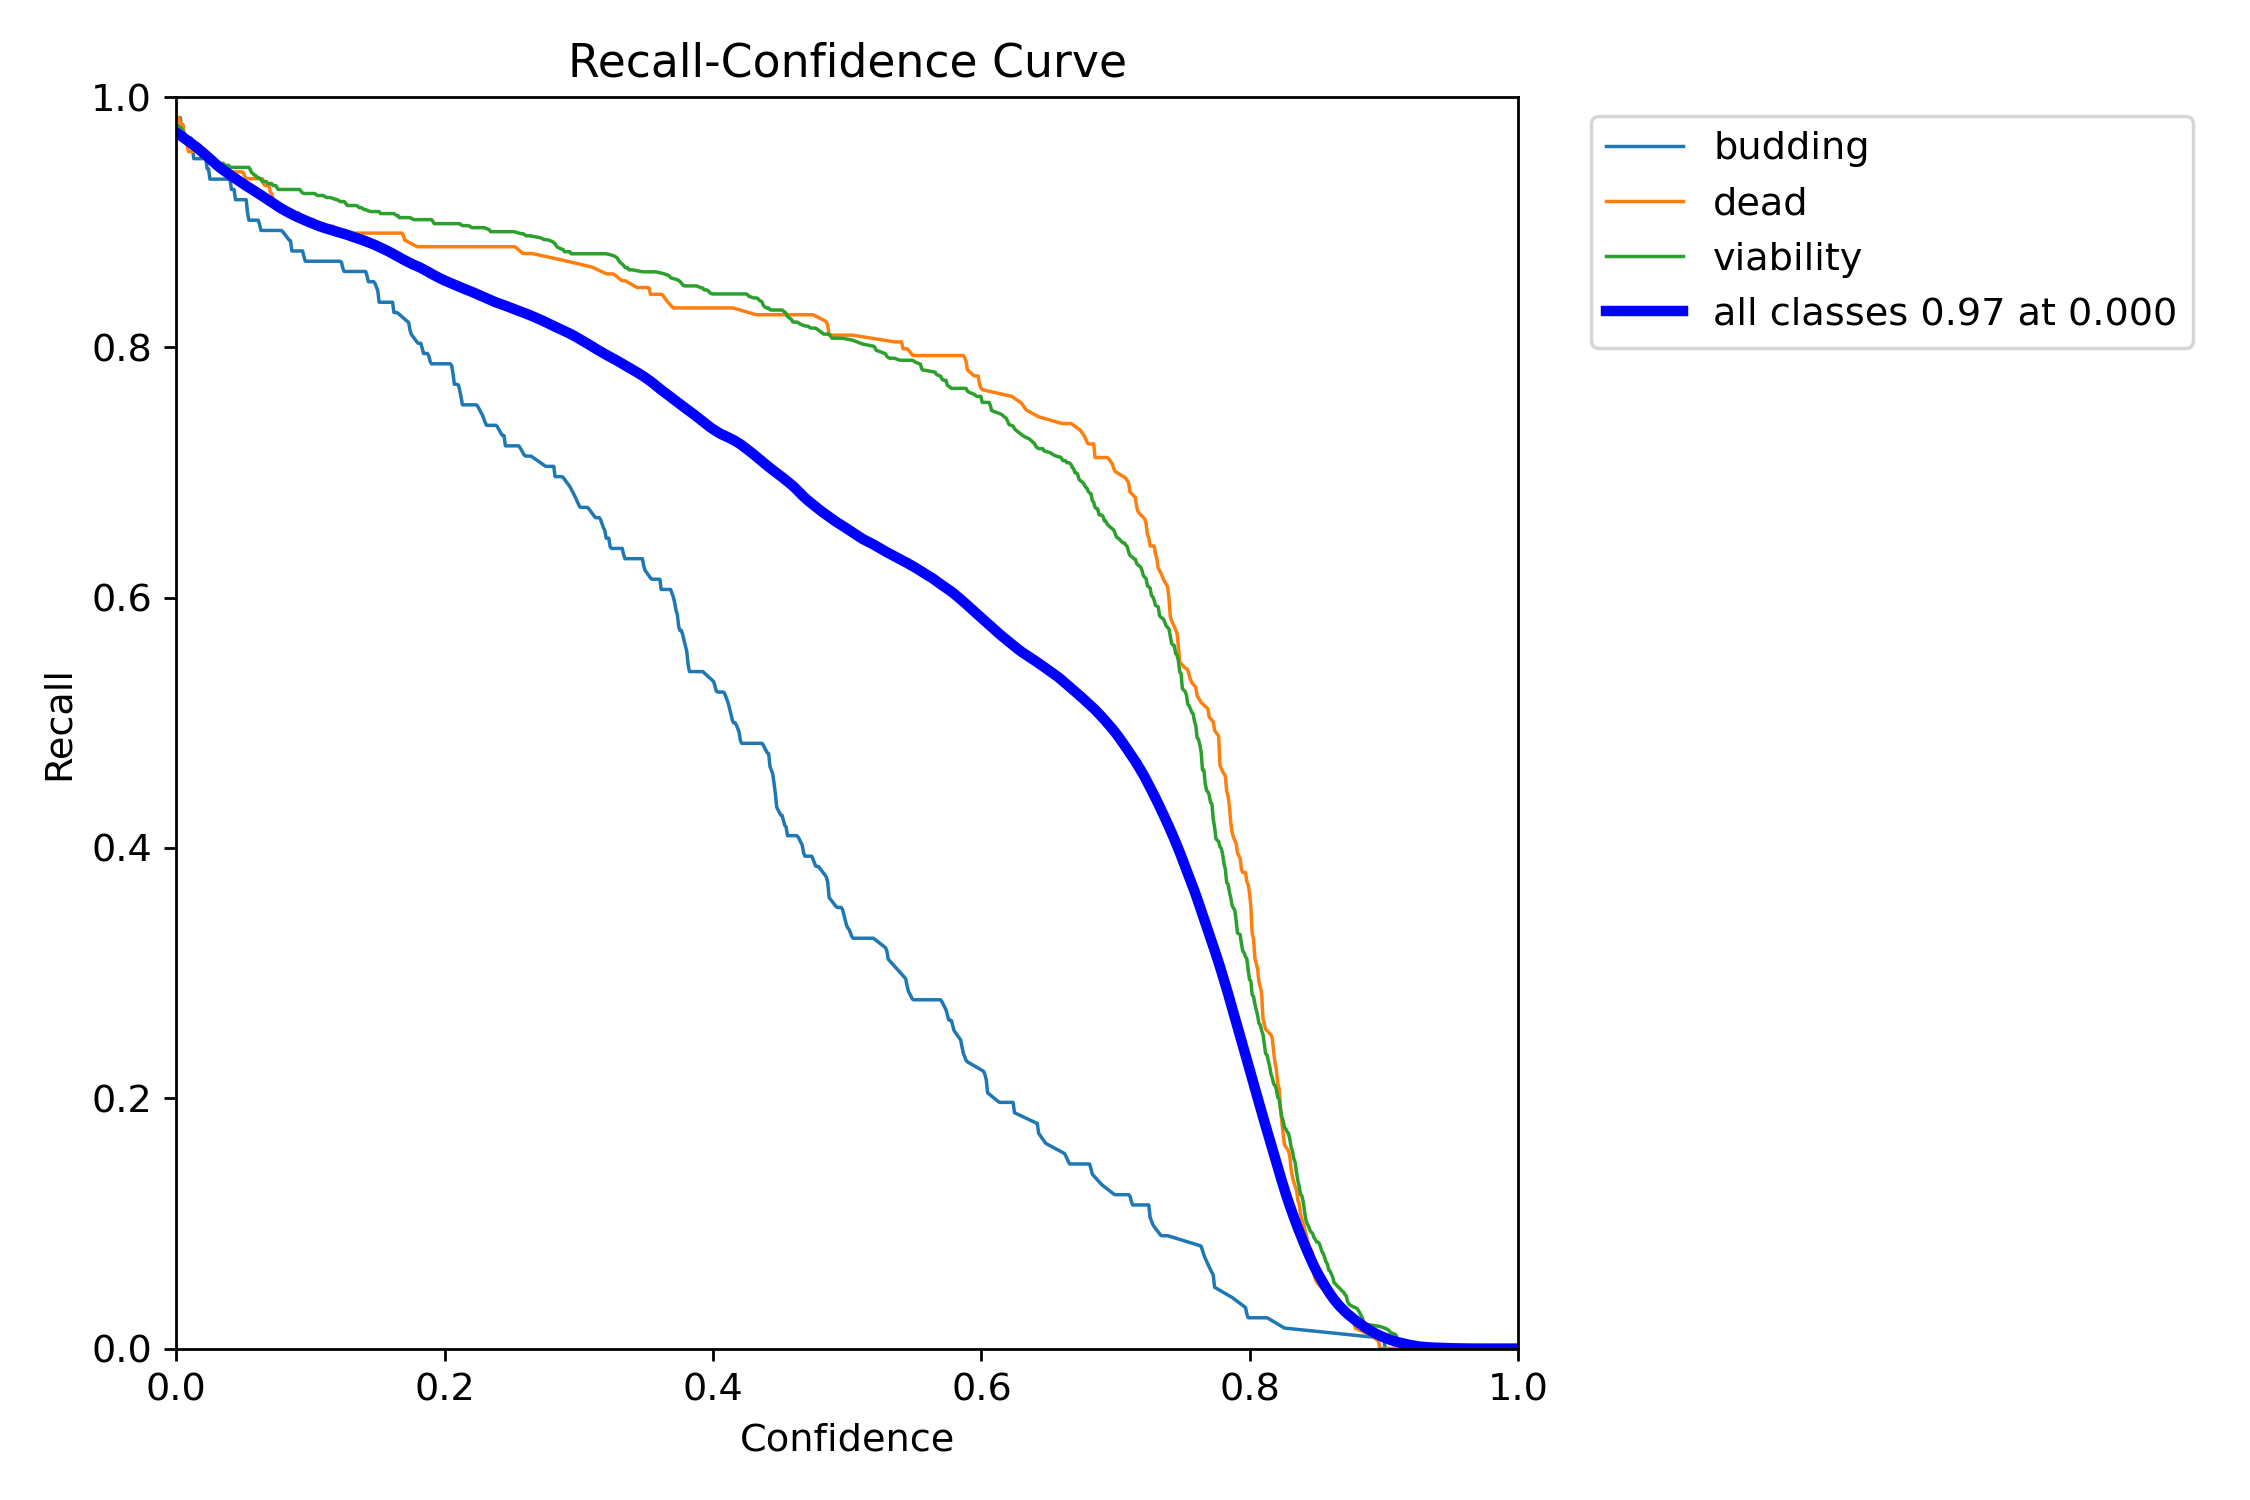

confusion_matrix_normalized.png


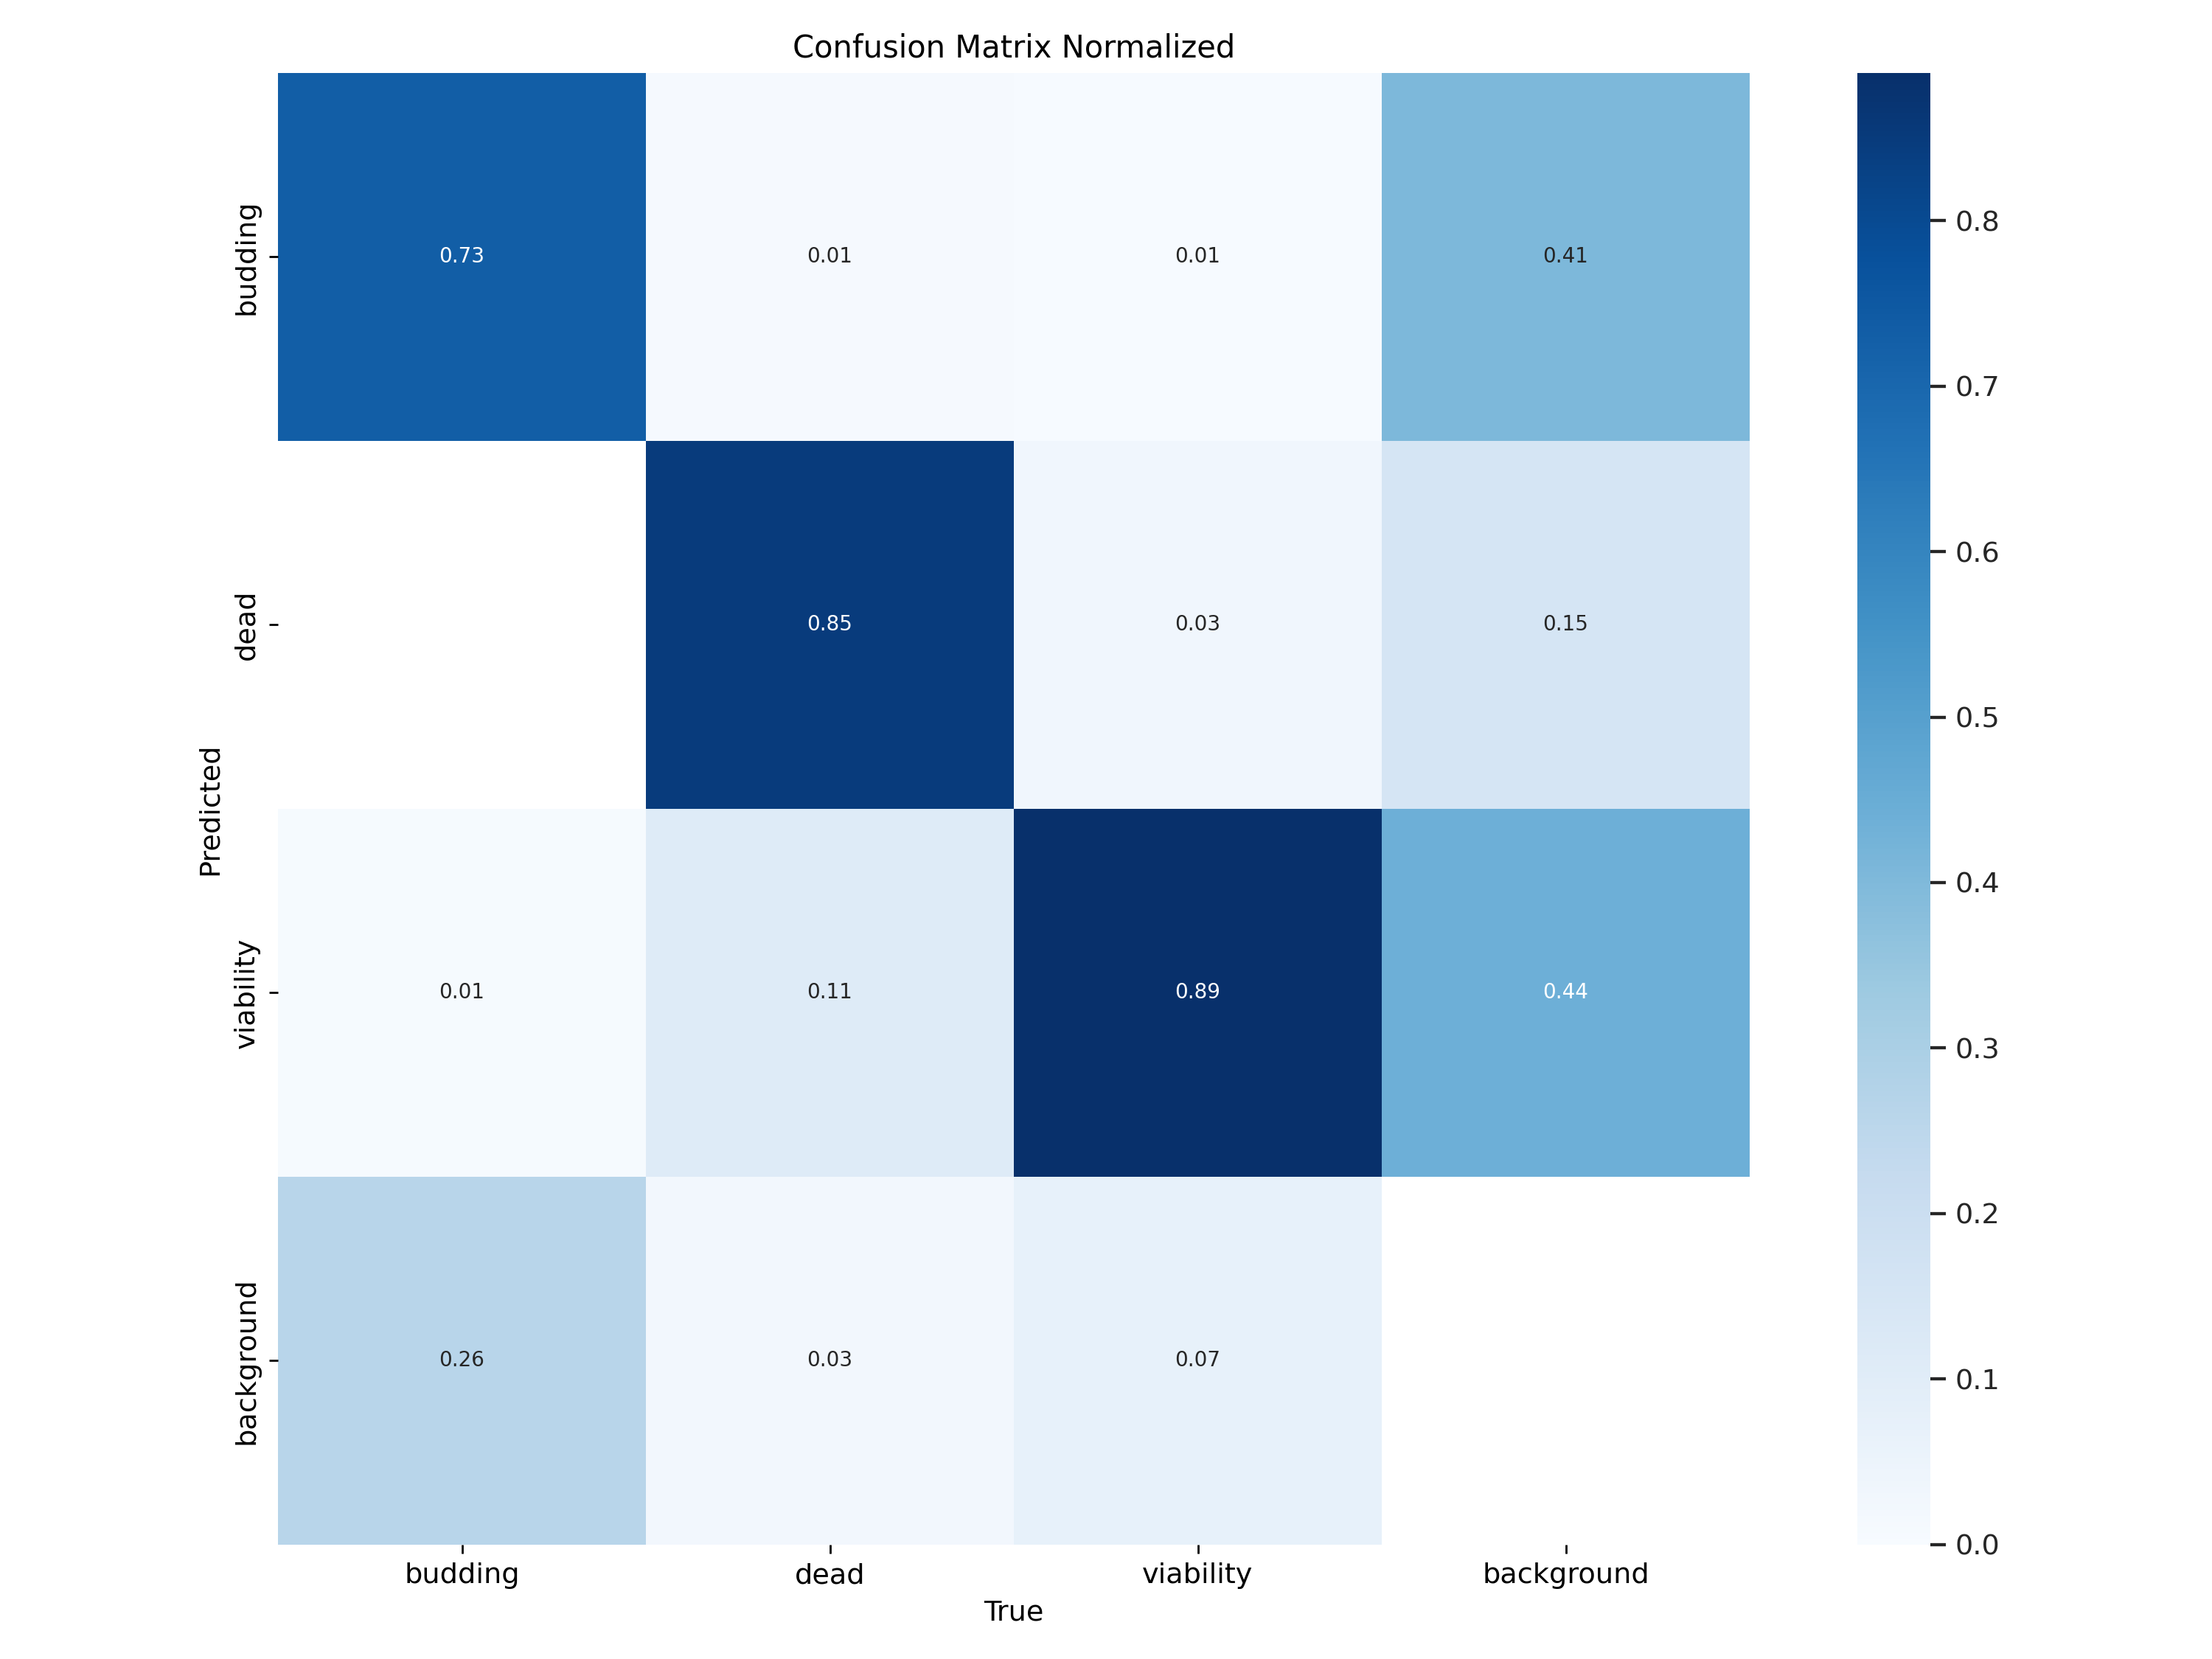

train_batch922.jpg


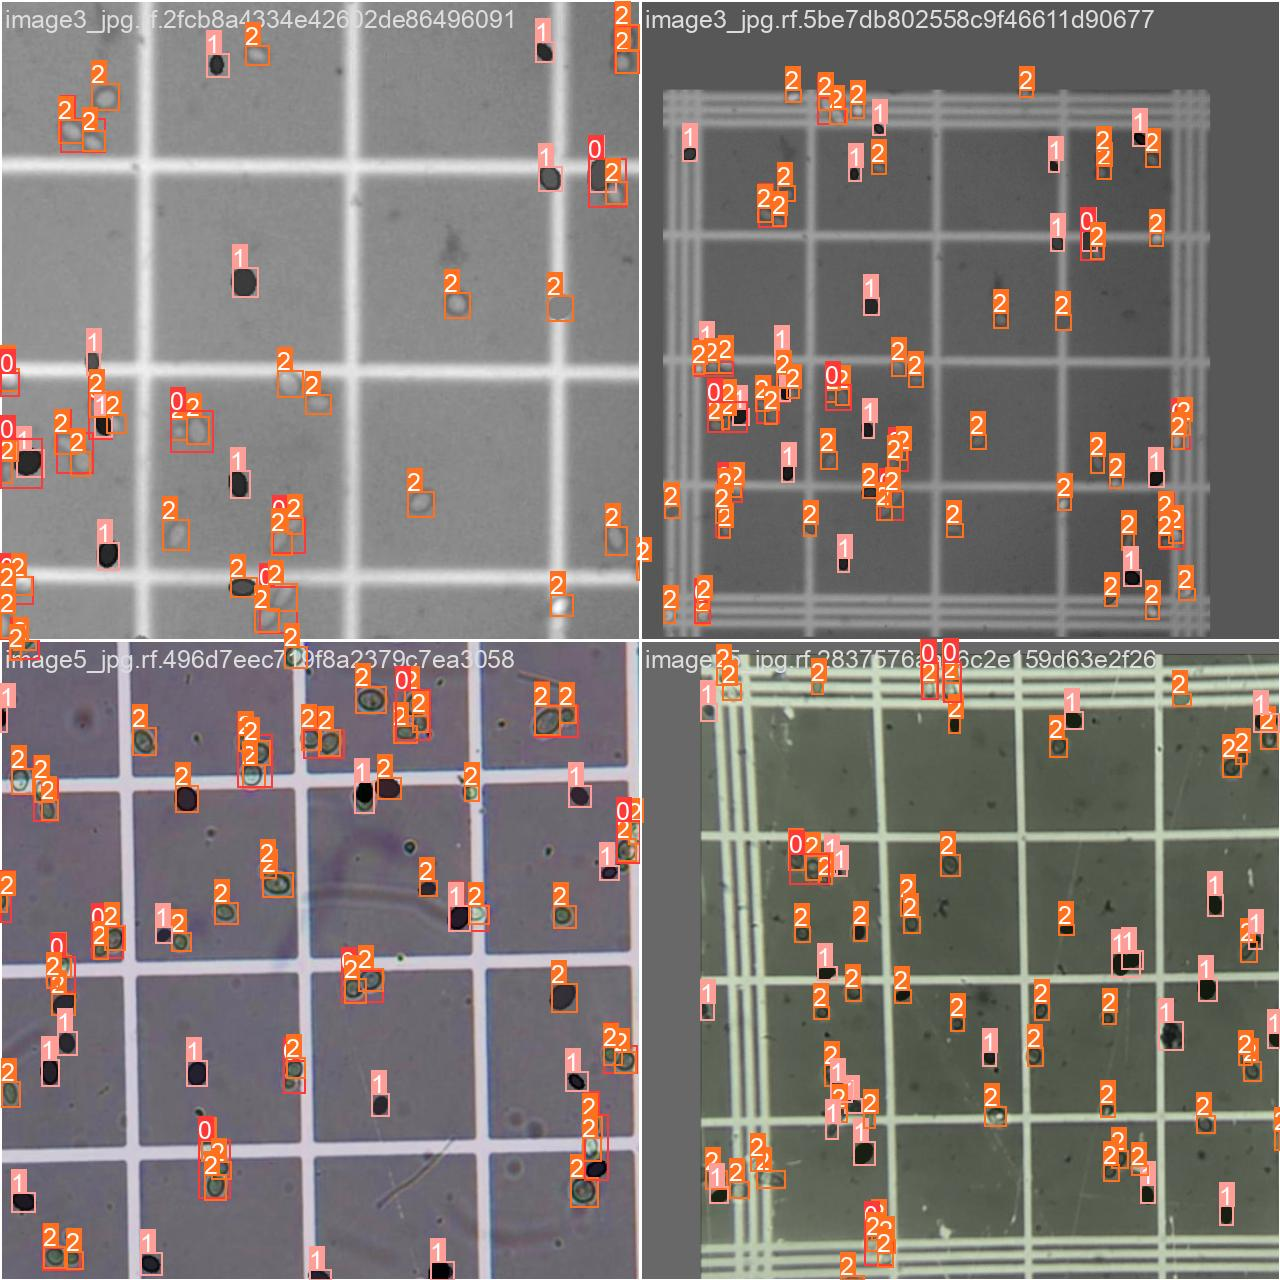

labels.jpg


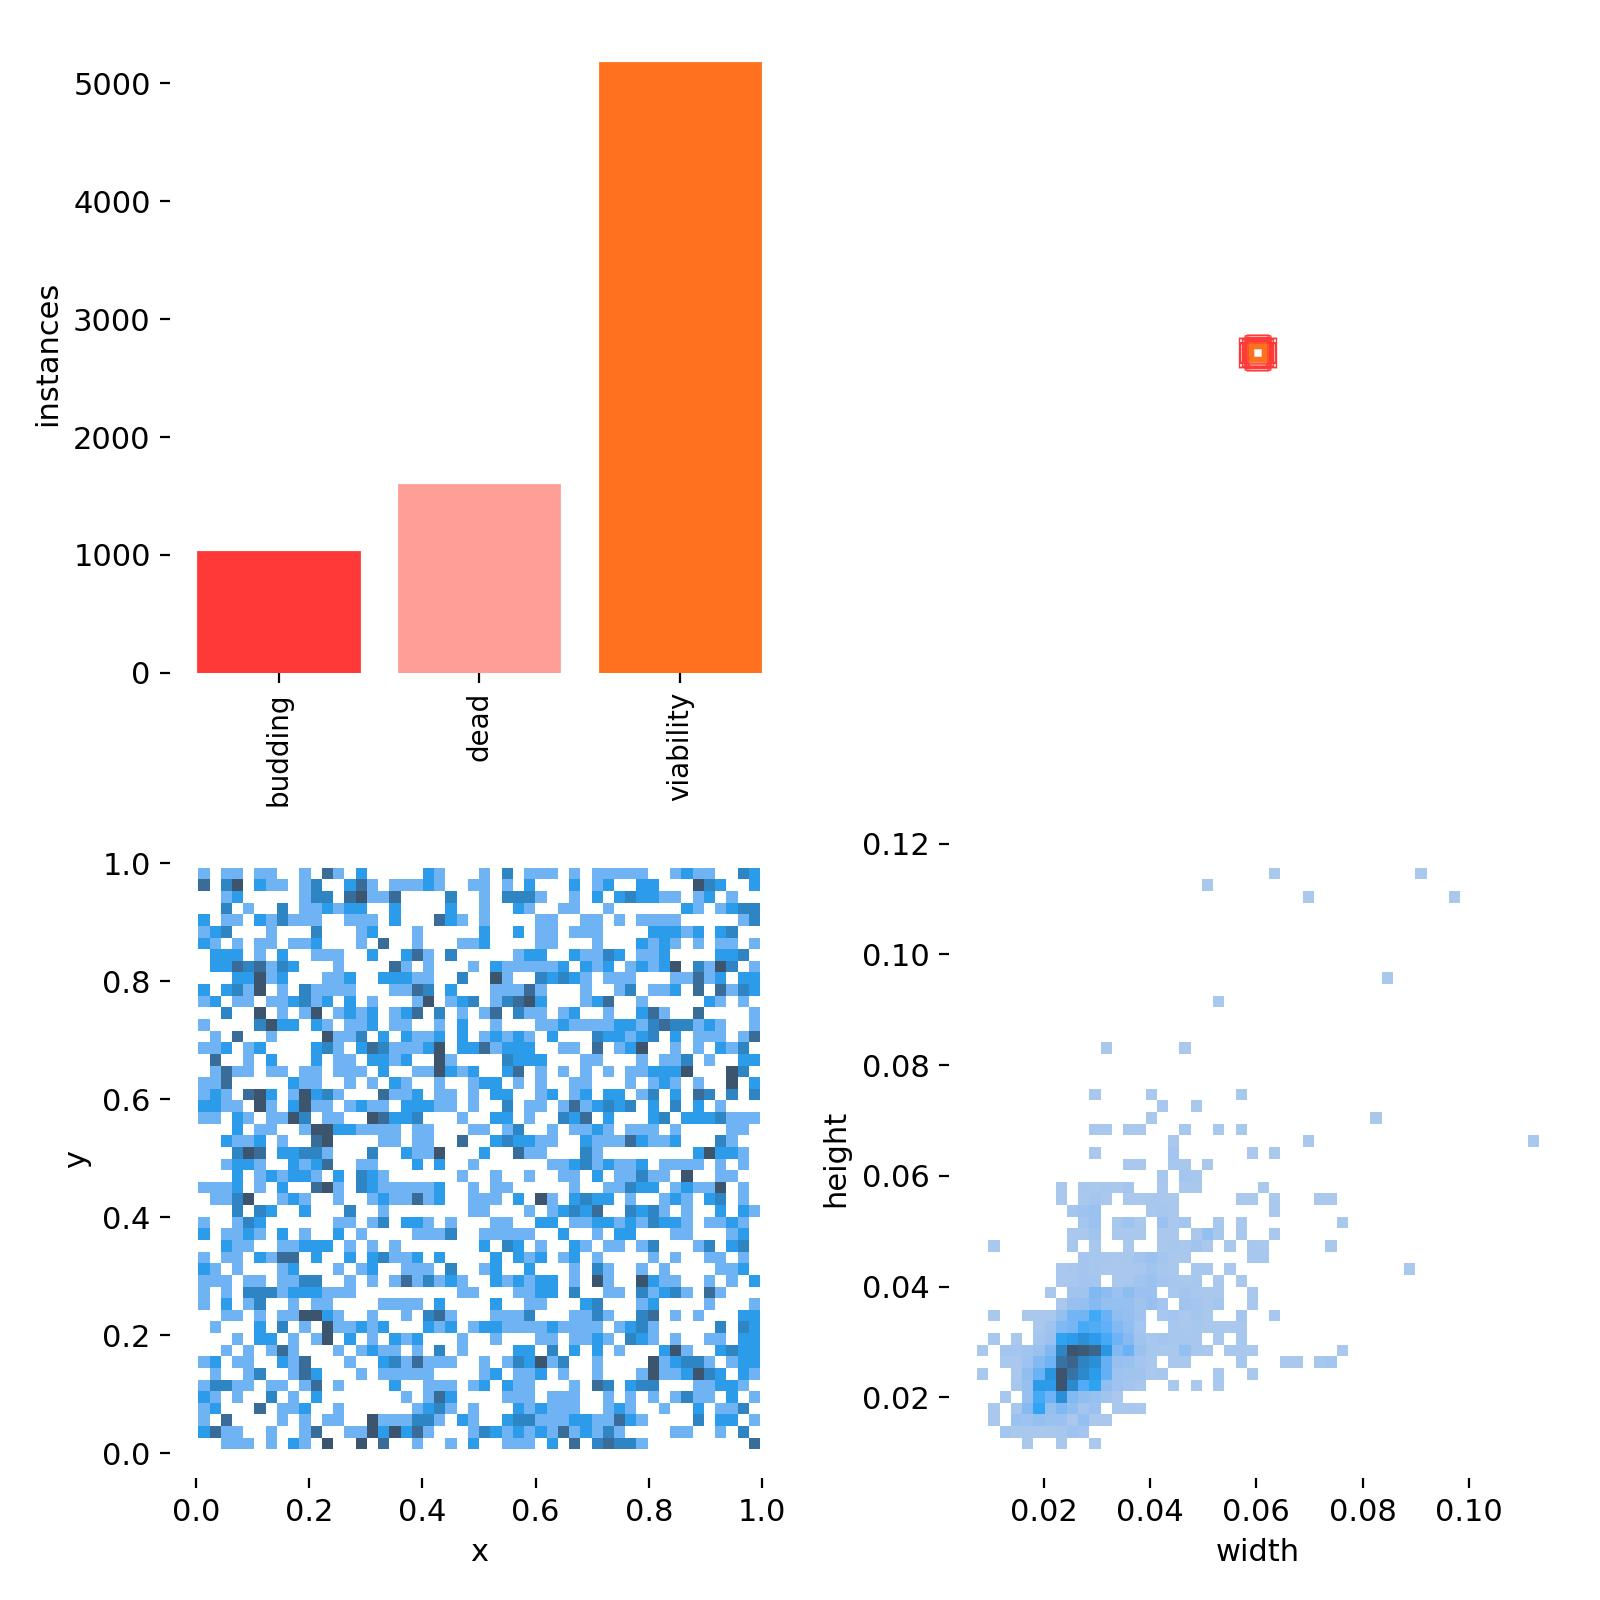

train_batch2.jpg


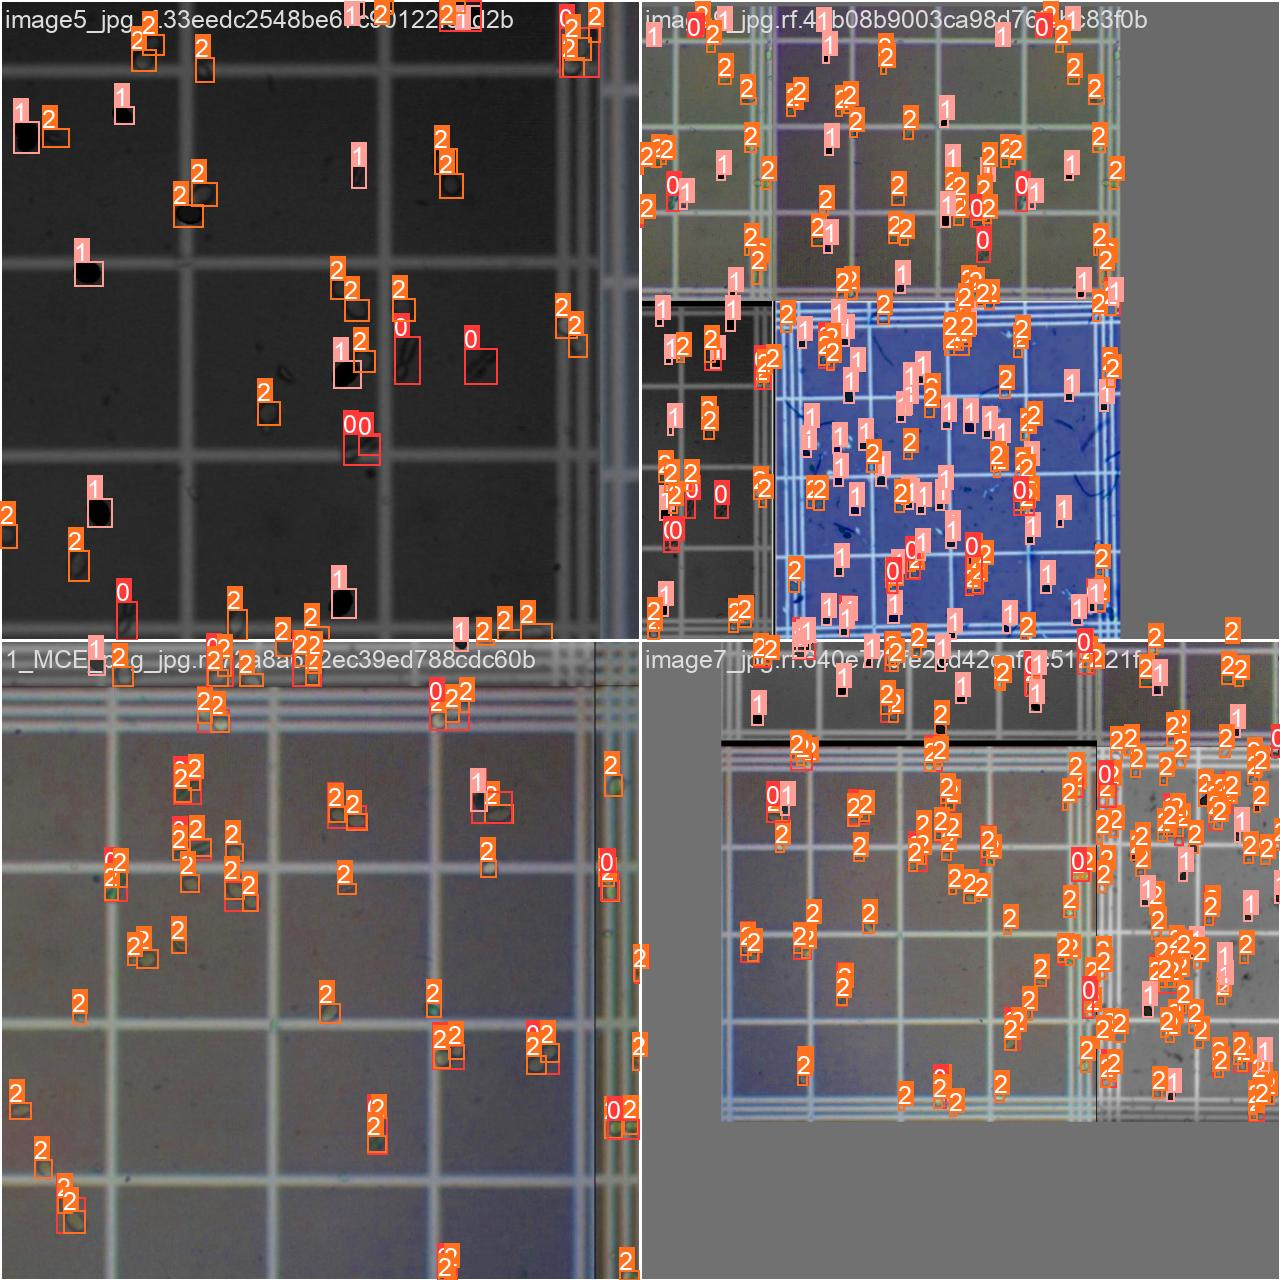

train_batch921.jpg


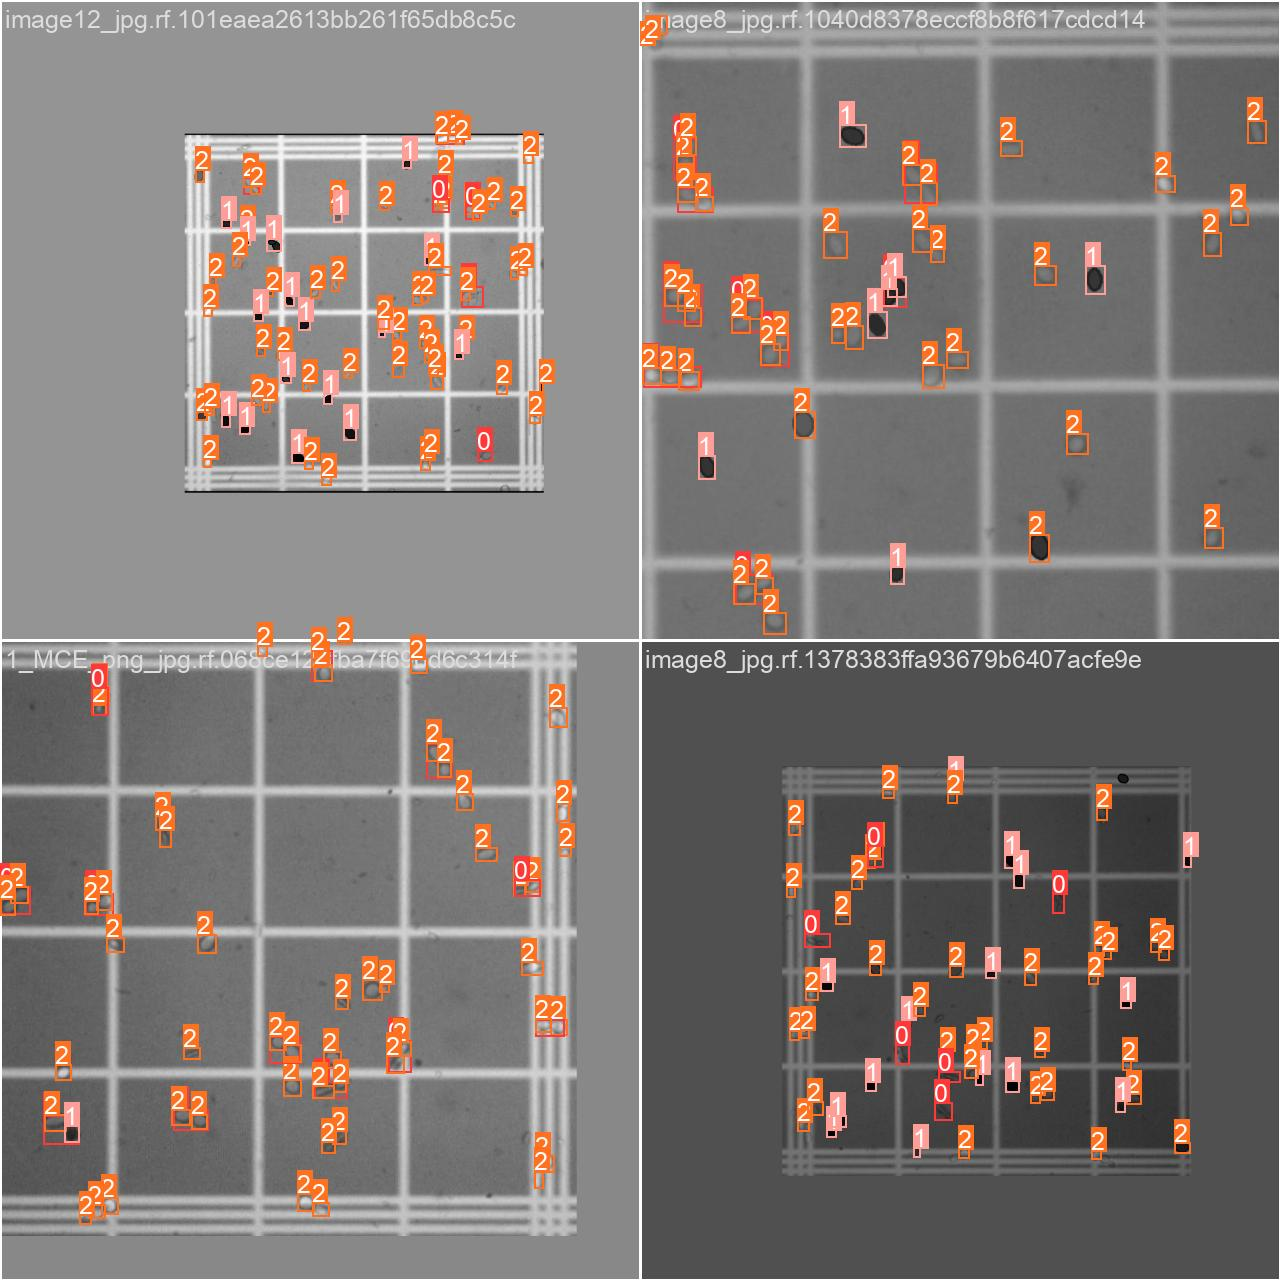

train_batch1.jpg


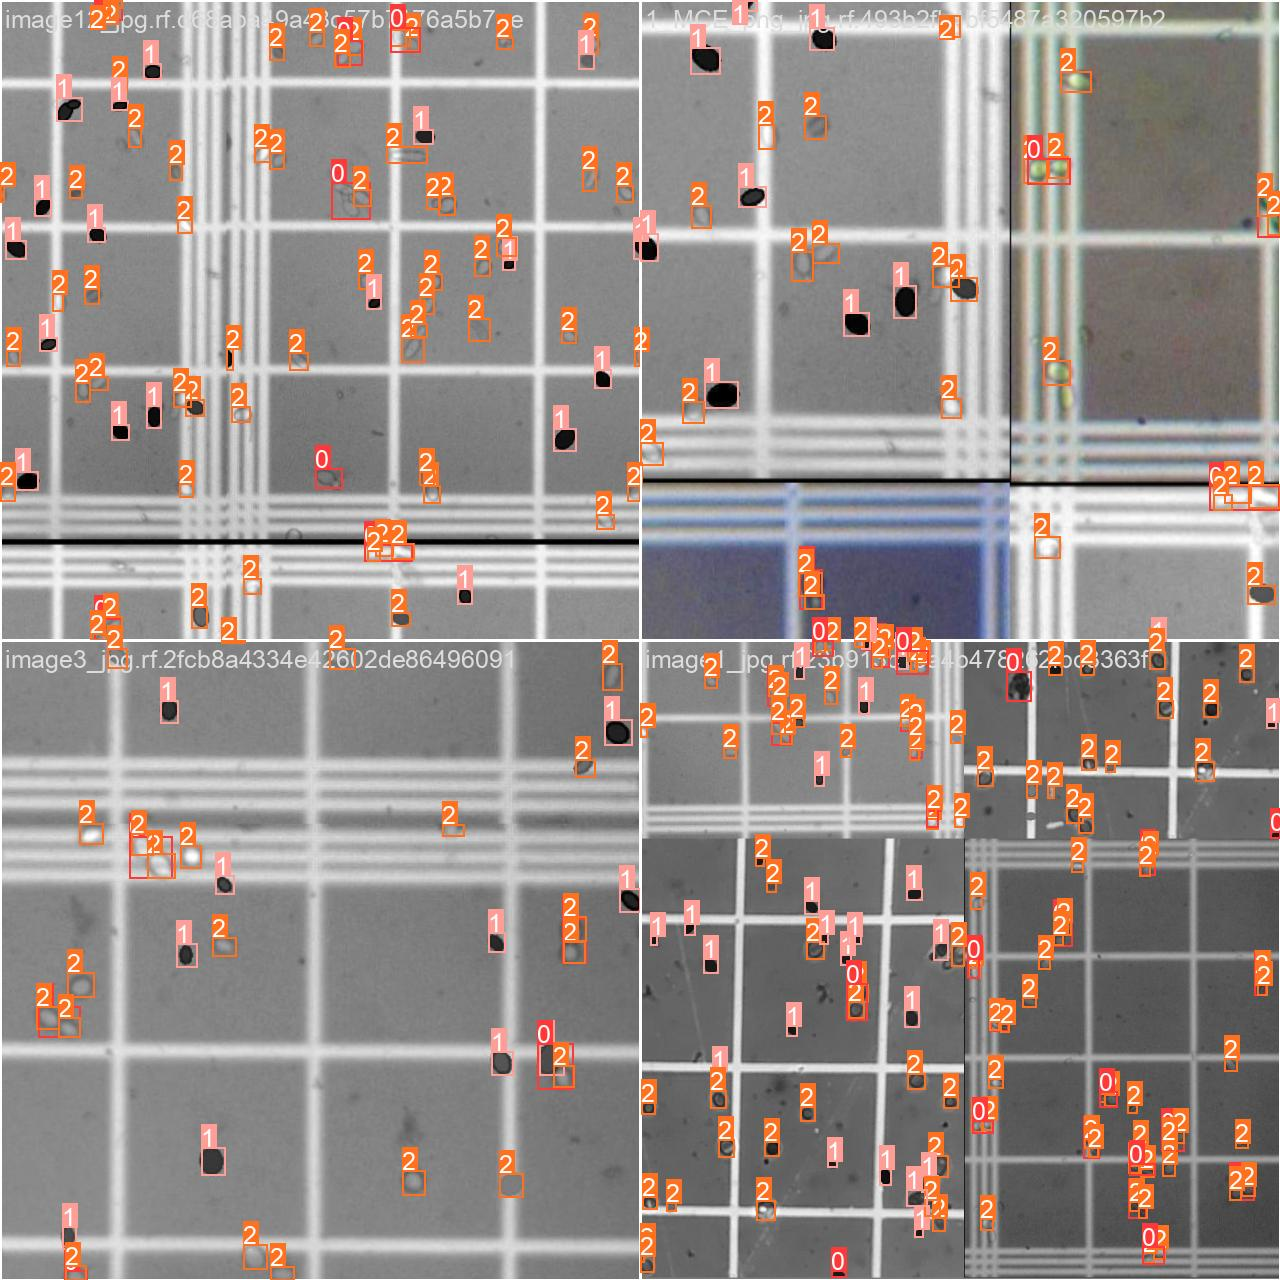

results.png


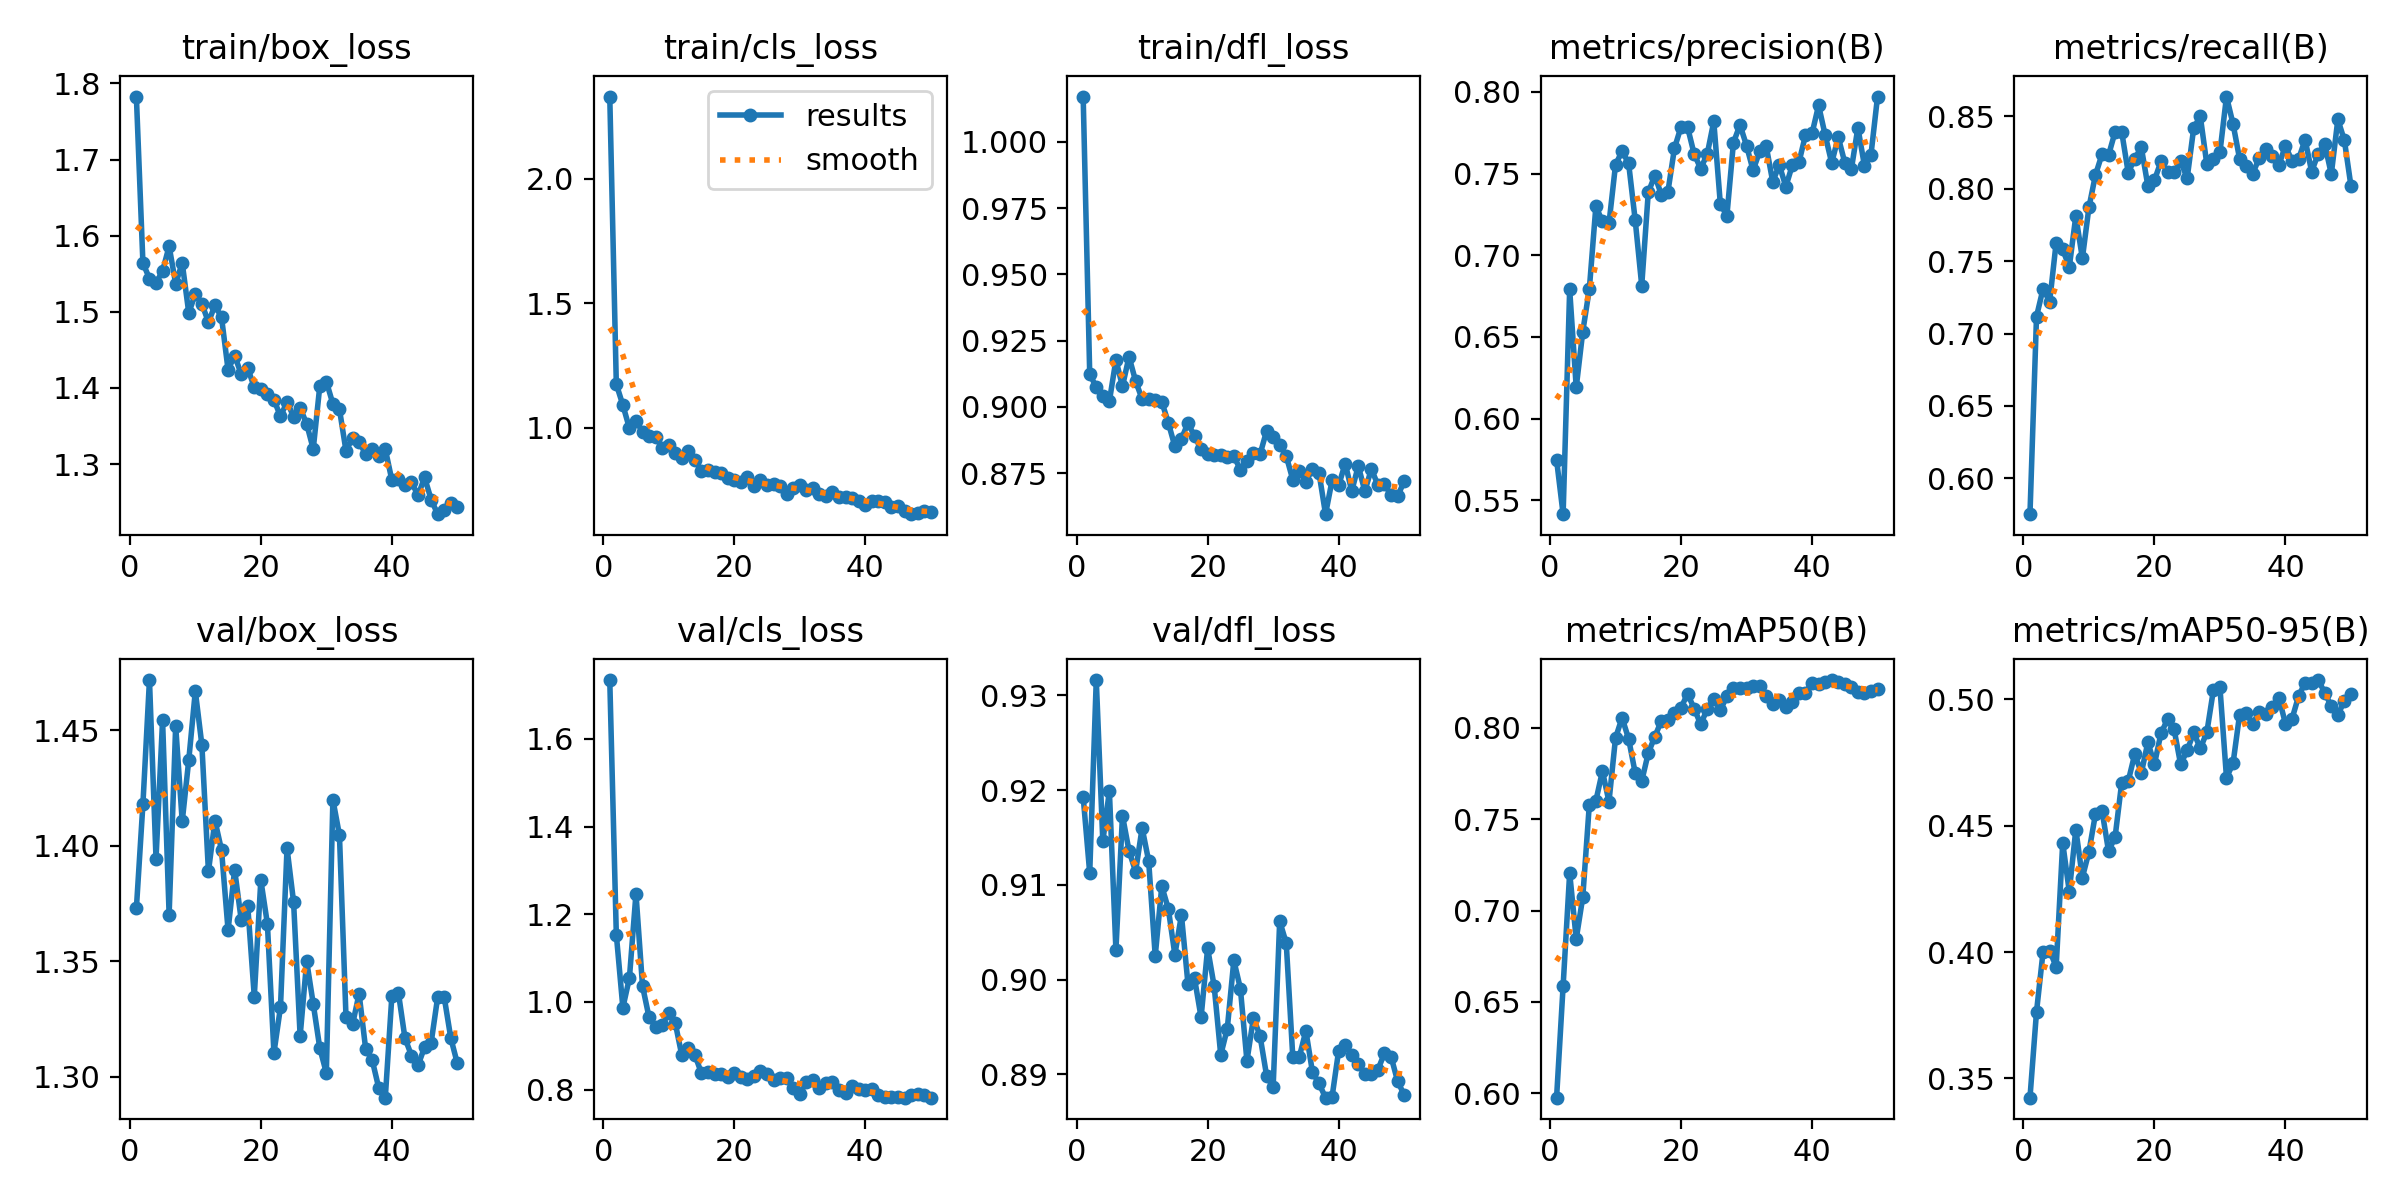

labels_correlogram.jpg


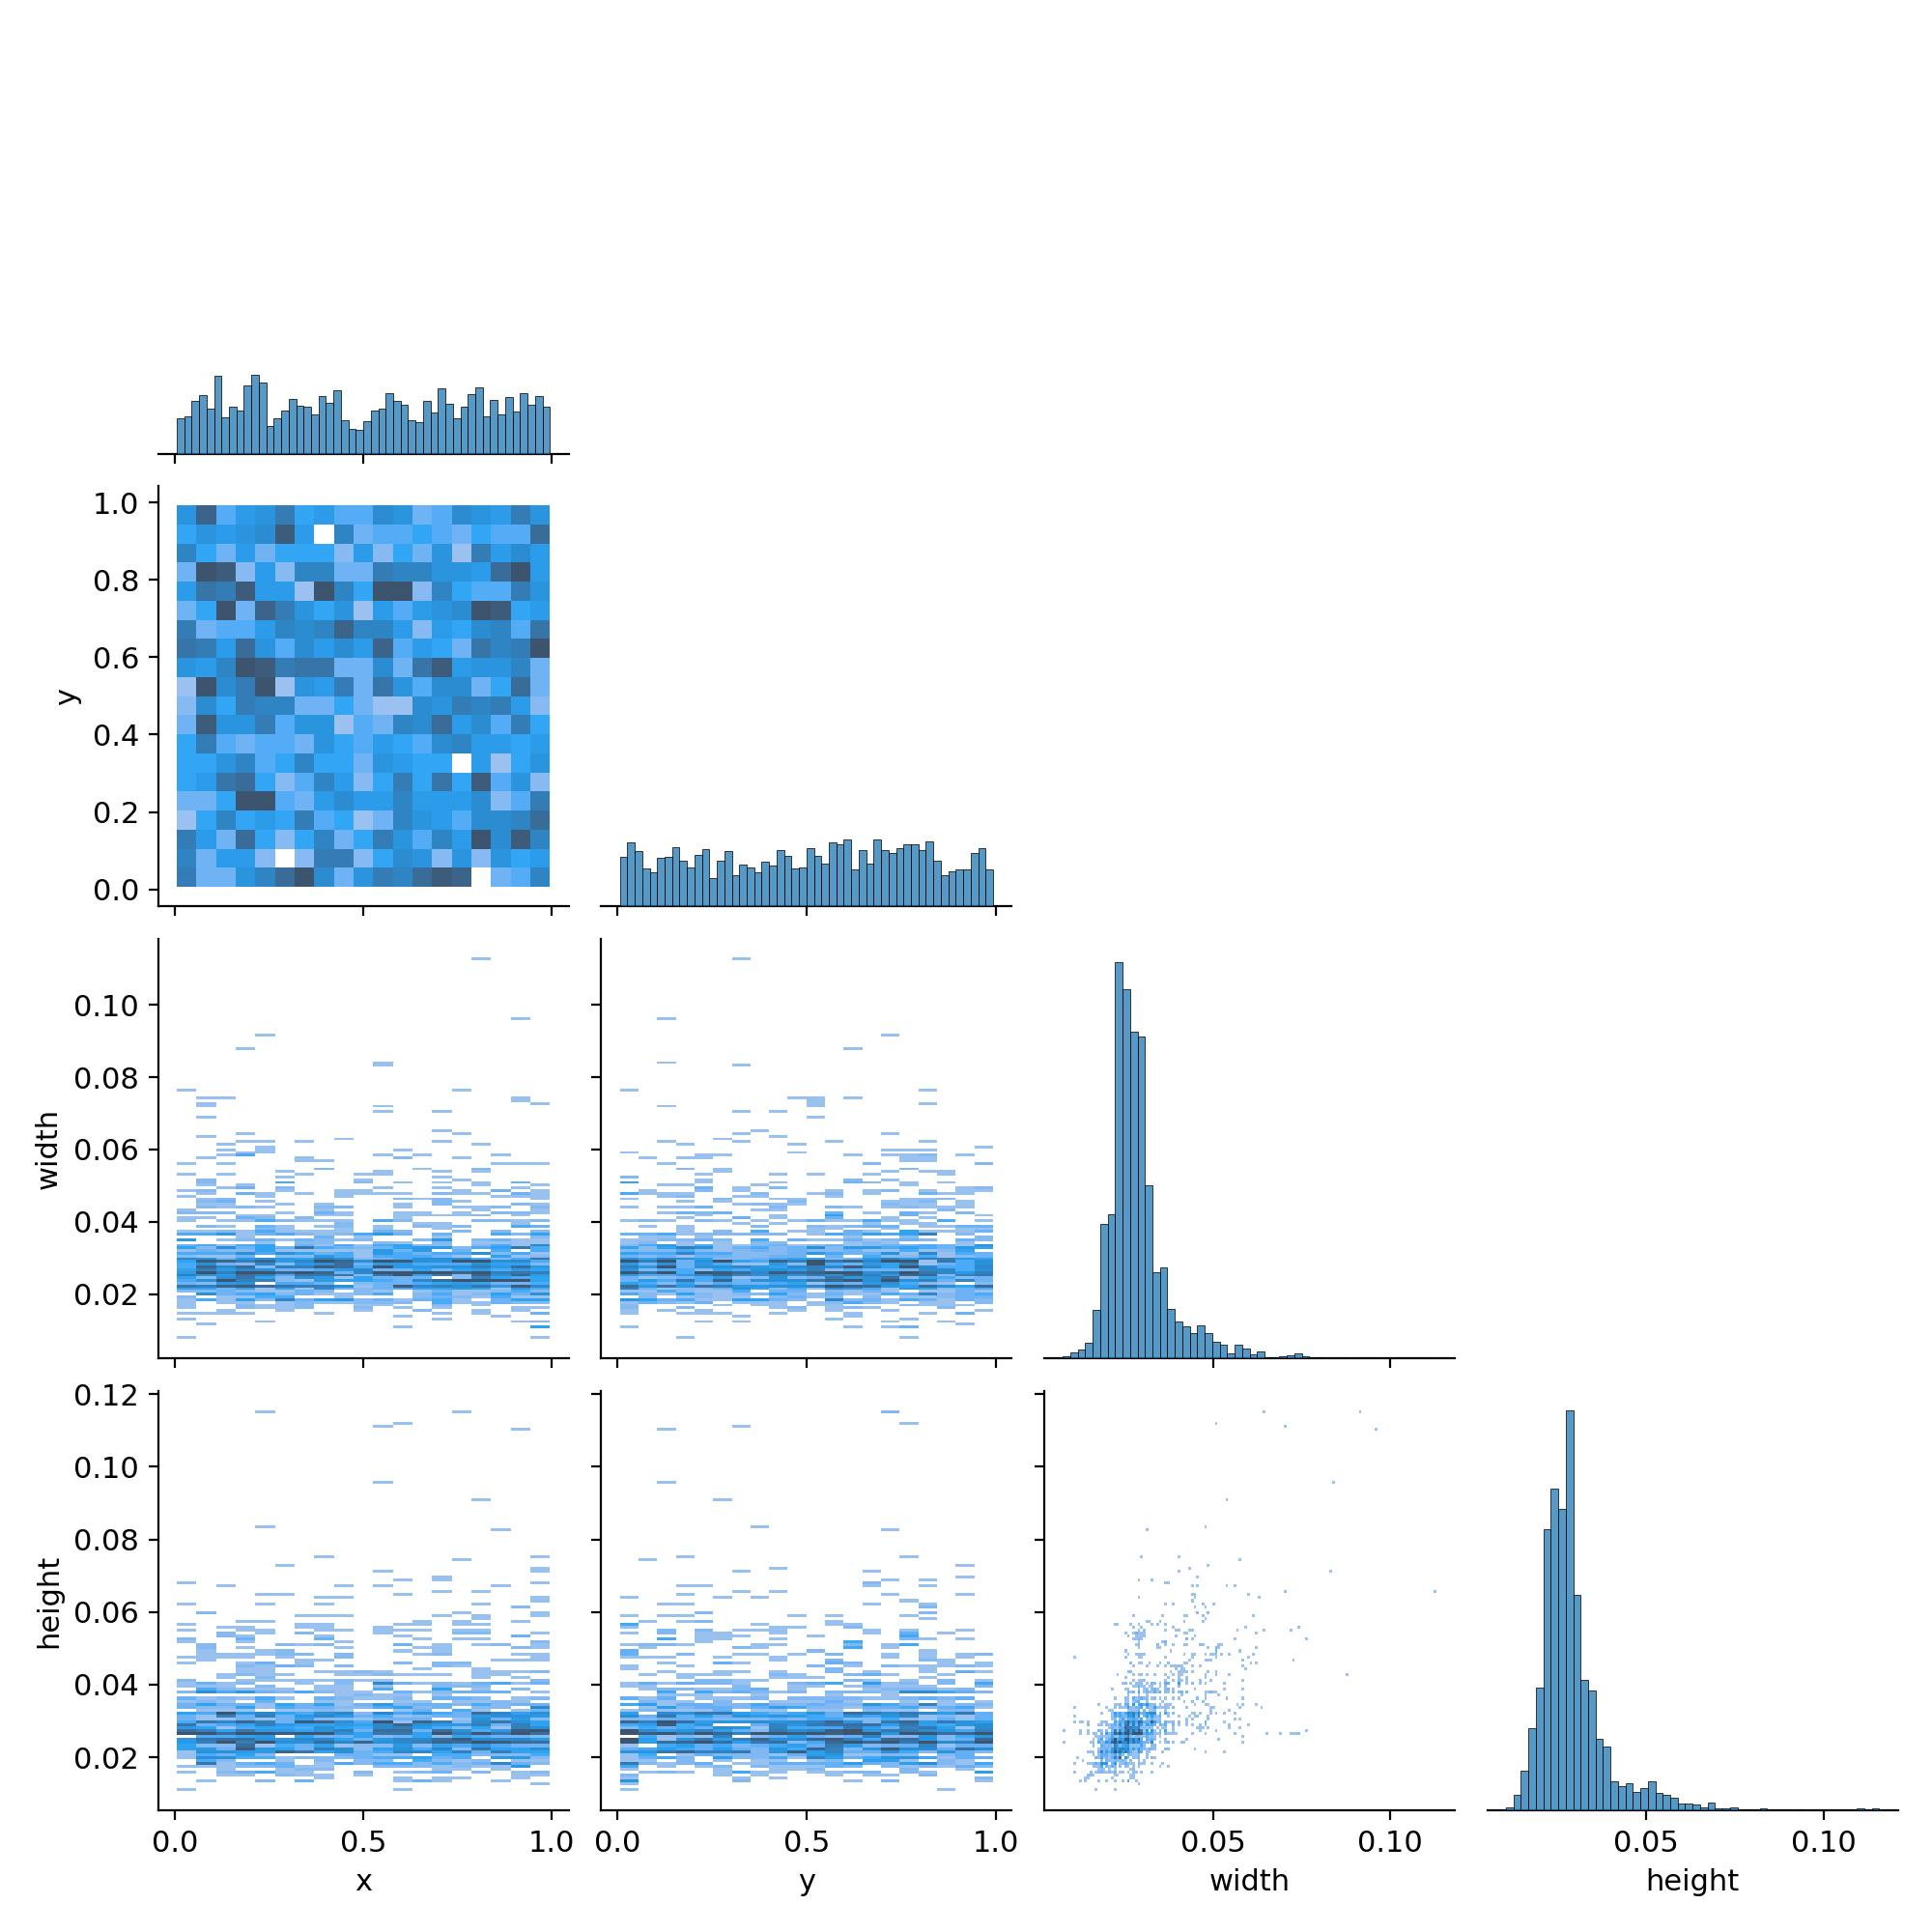

P_curve.png


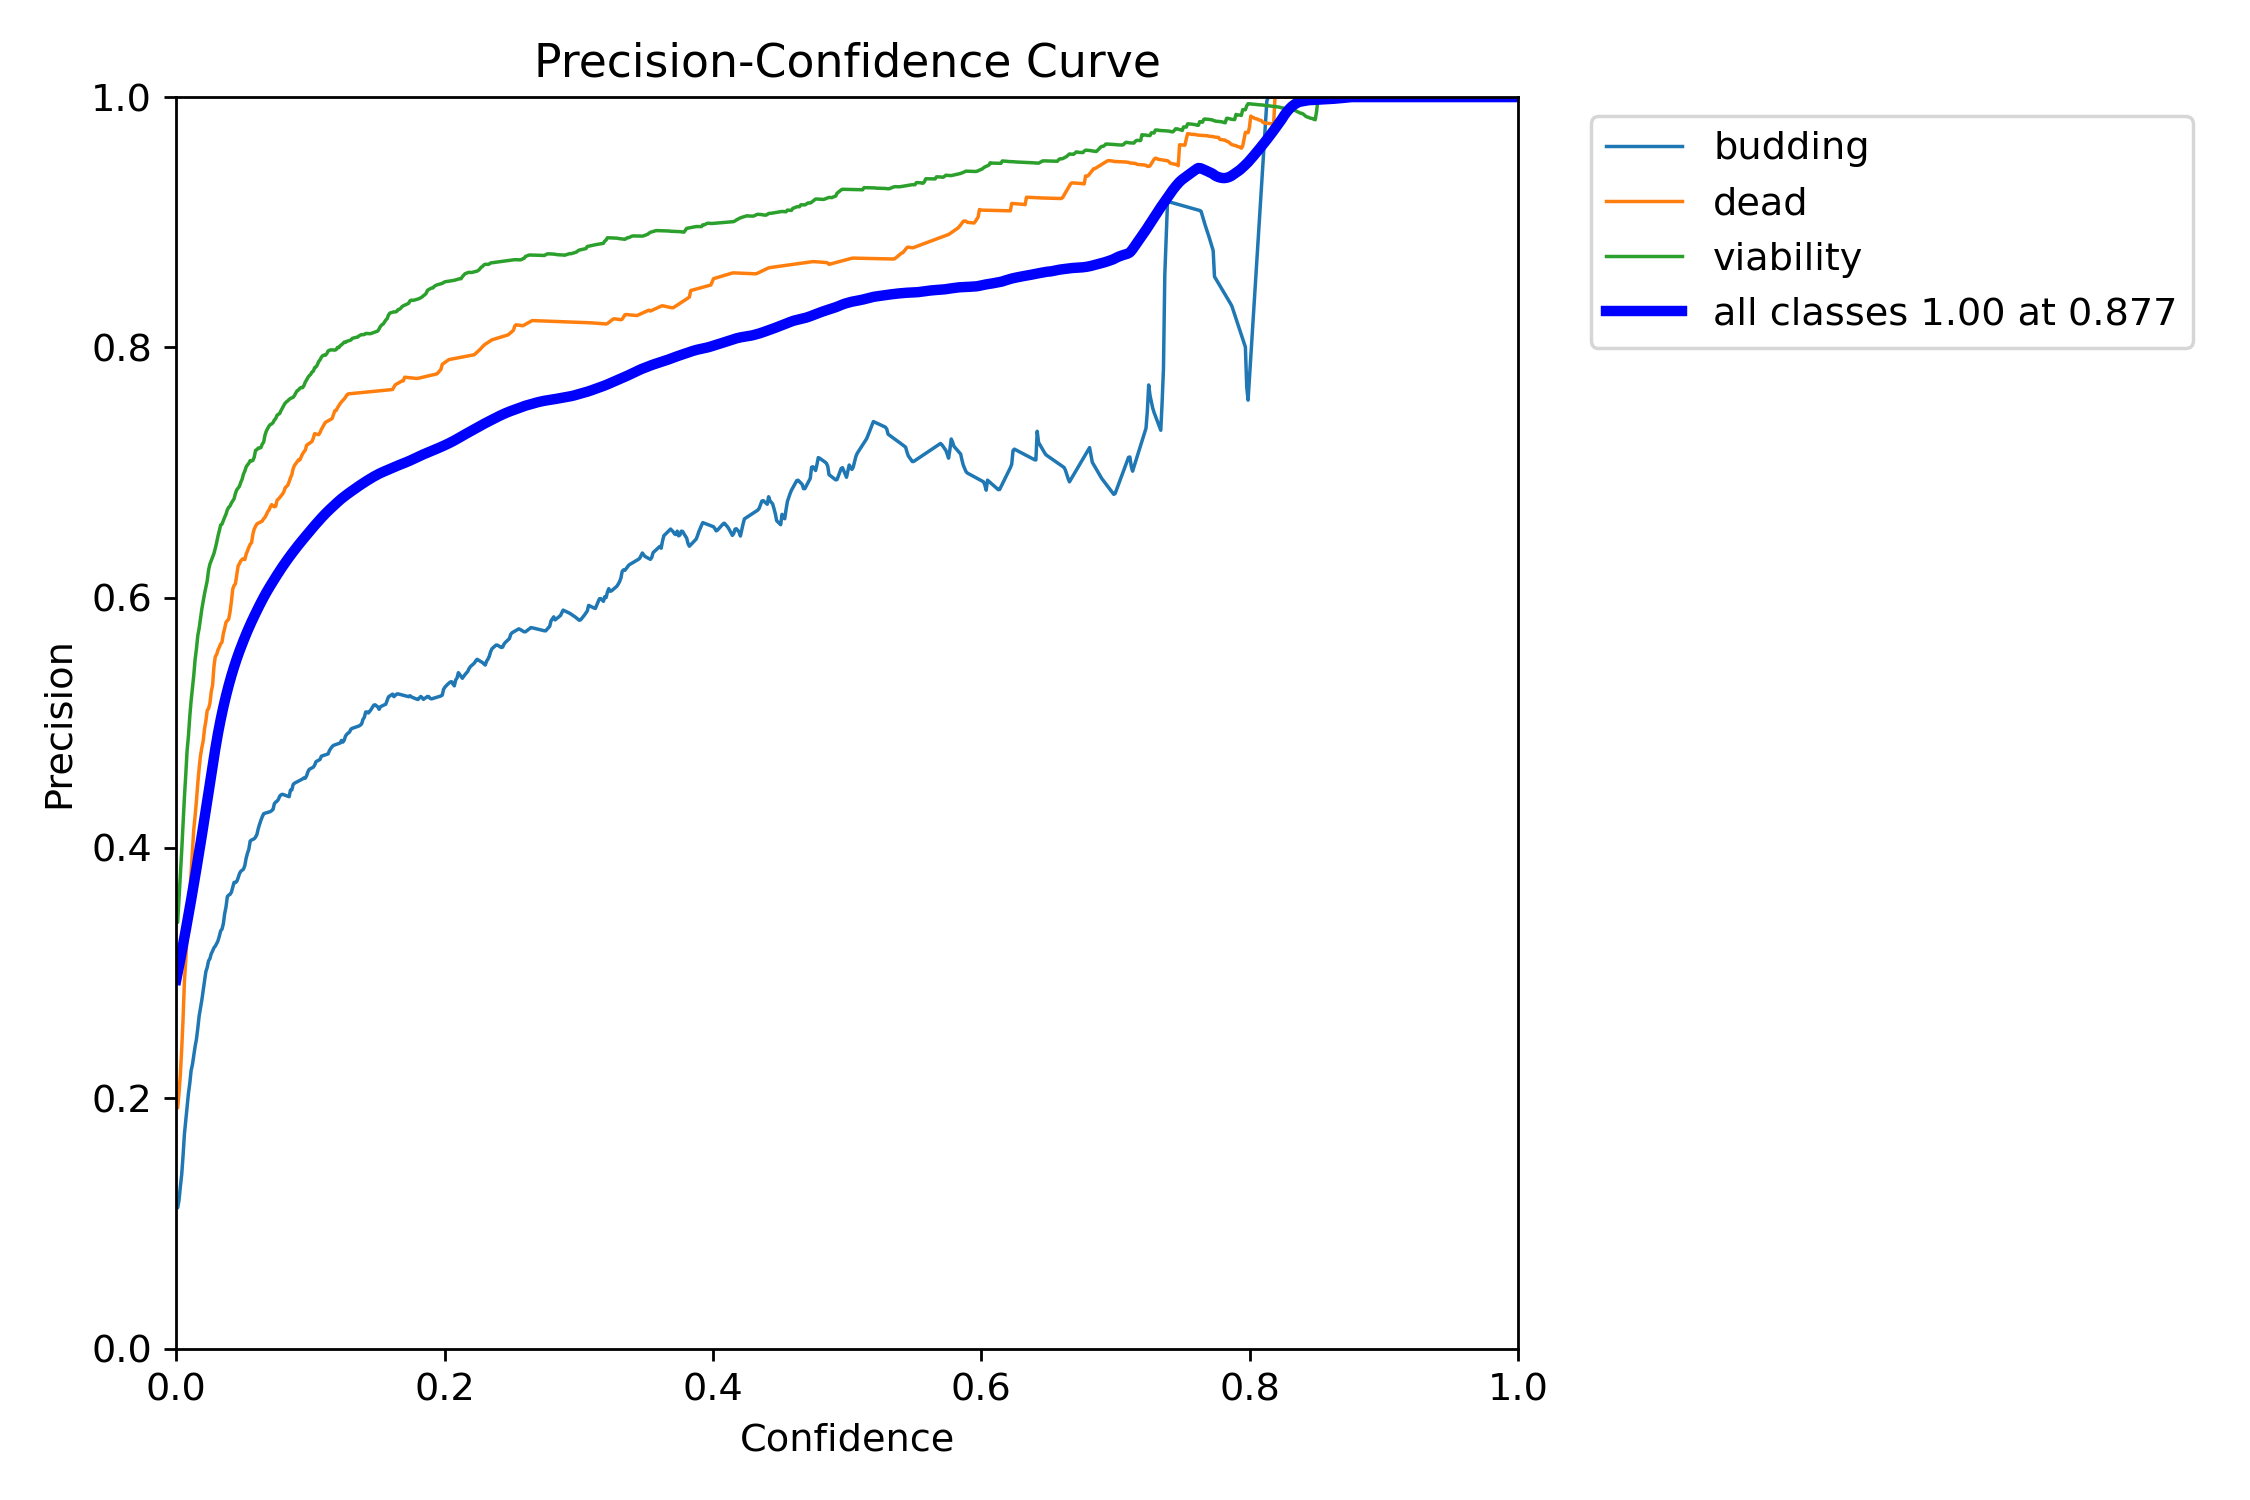

val_batch1_labels.jpg


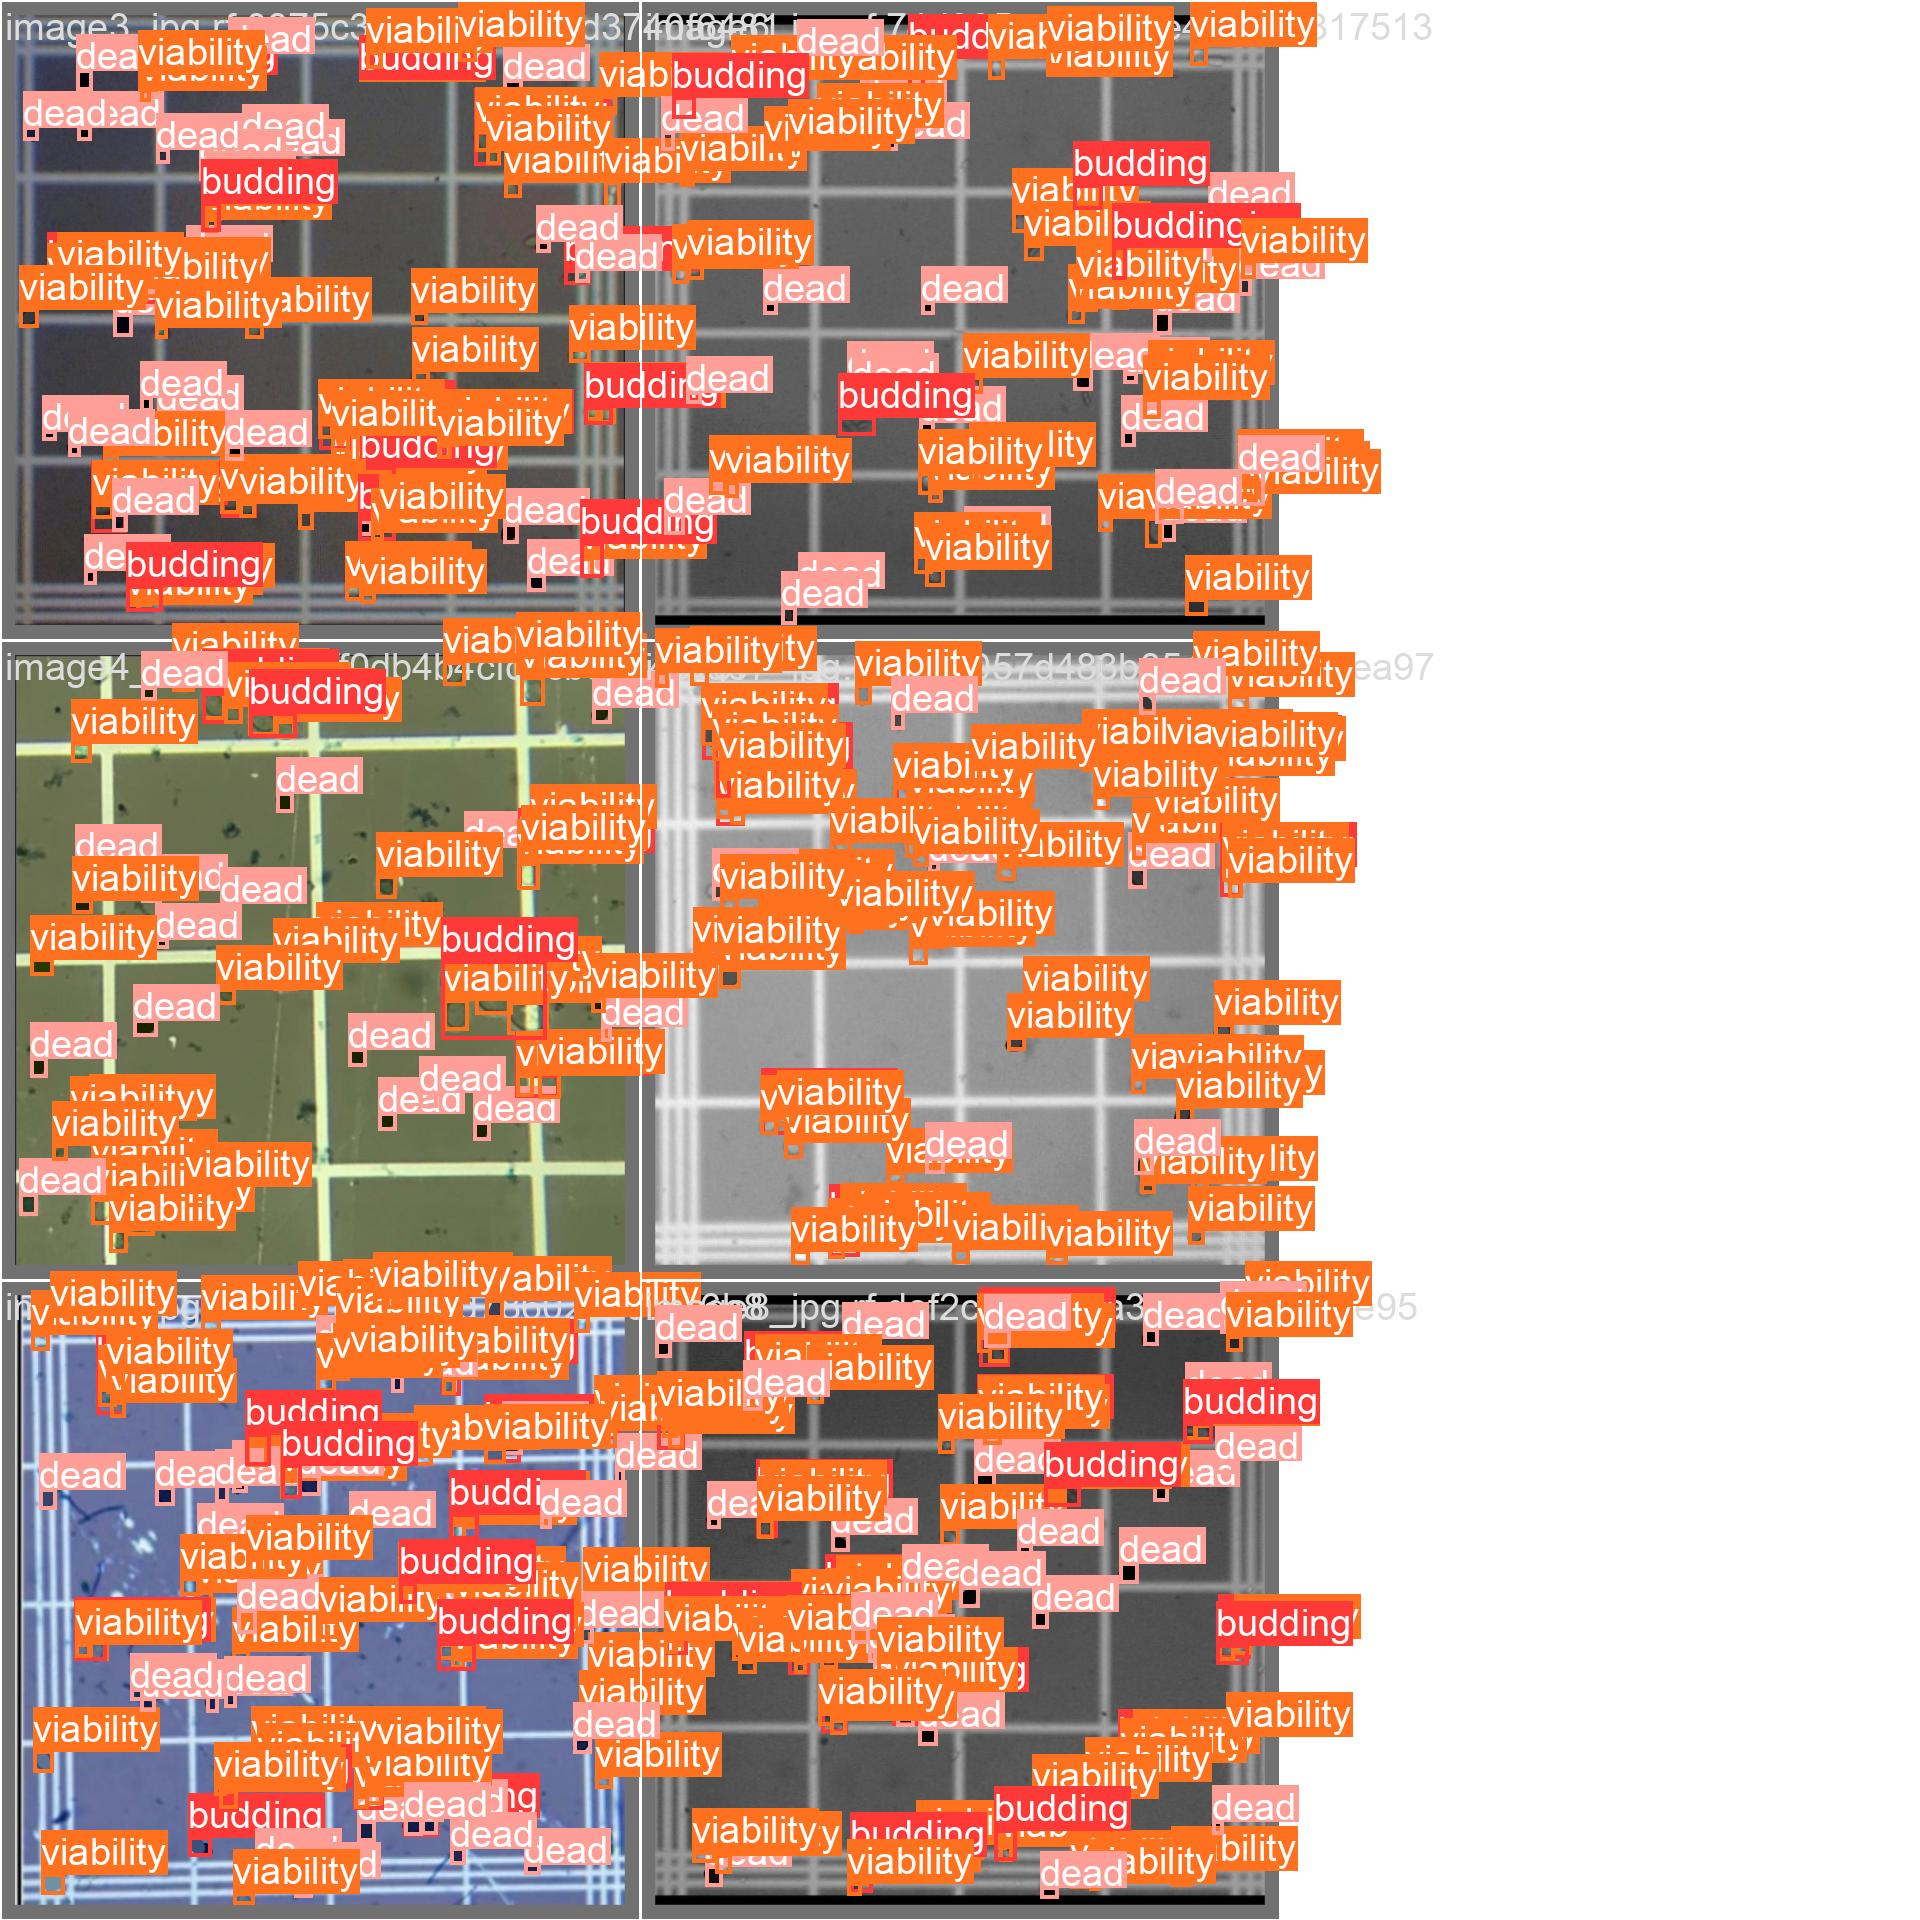

PR_curve.png


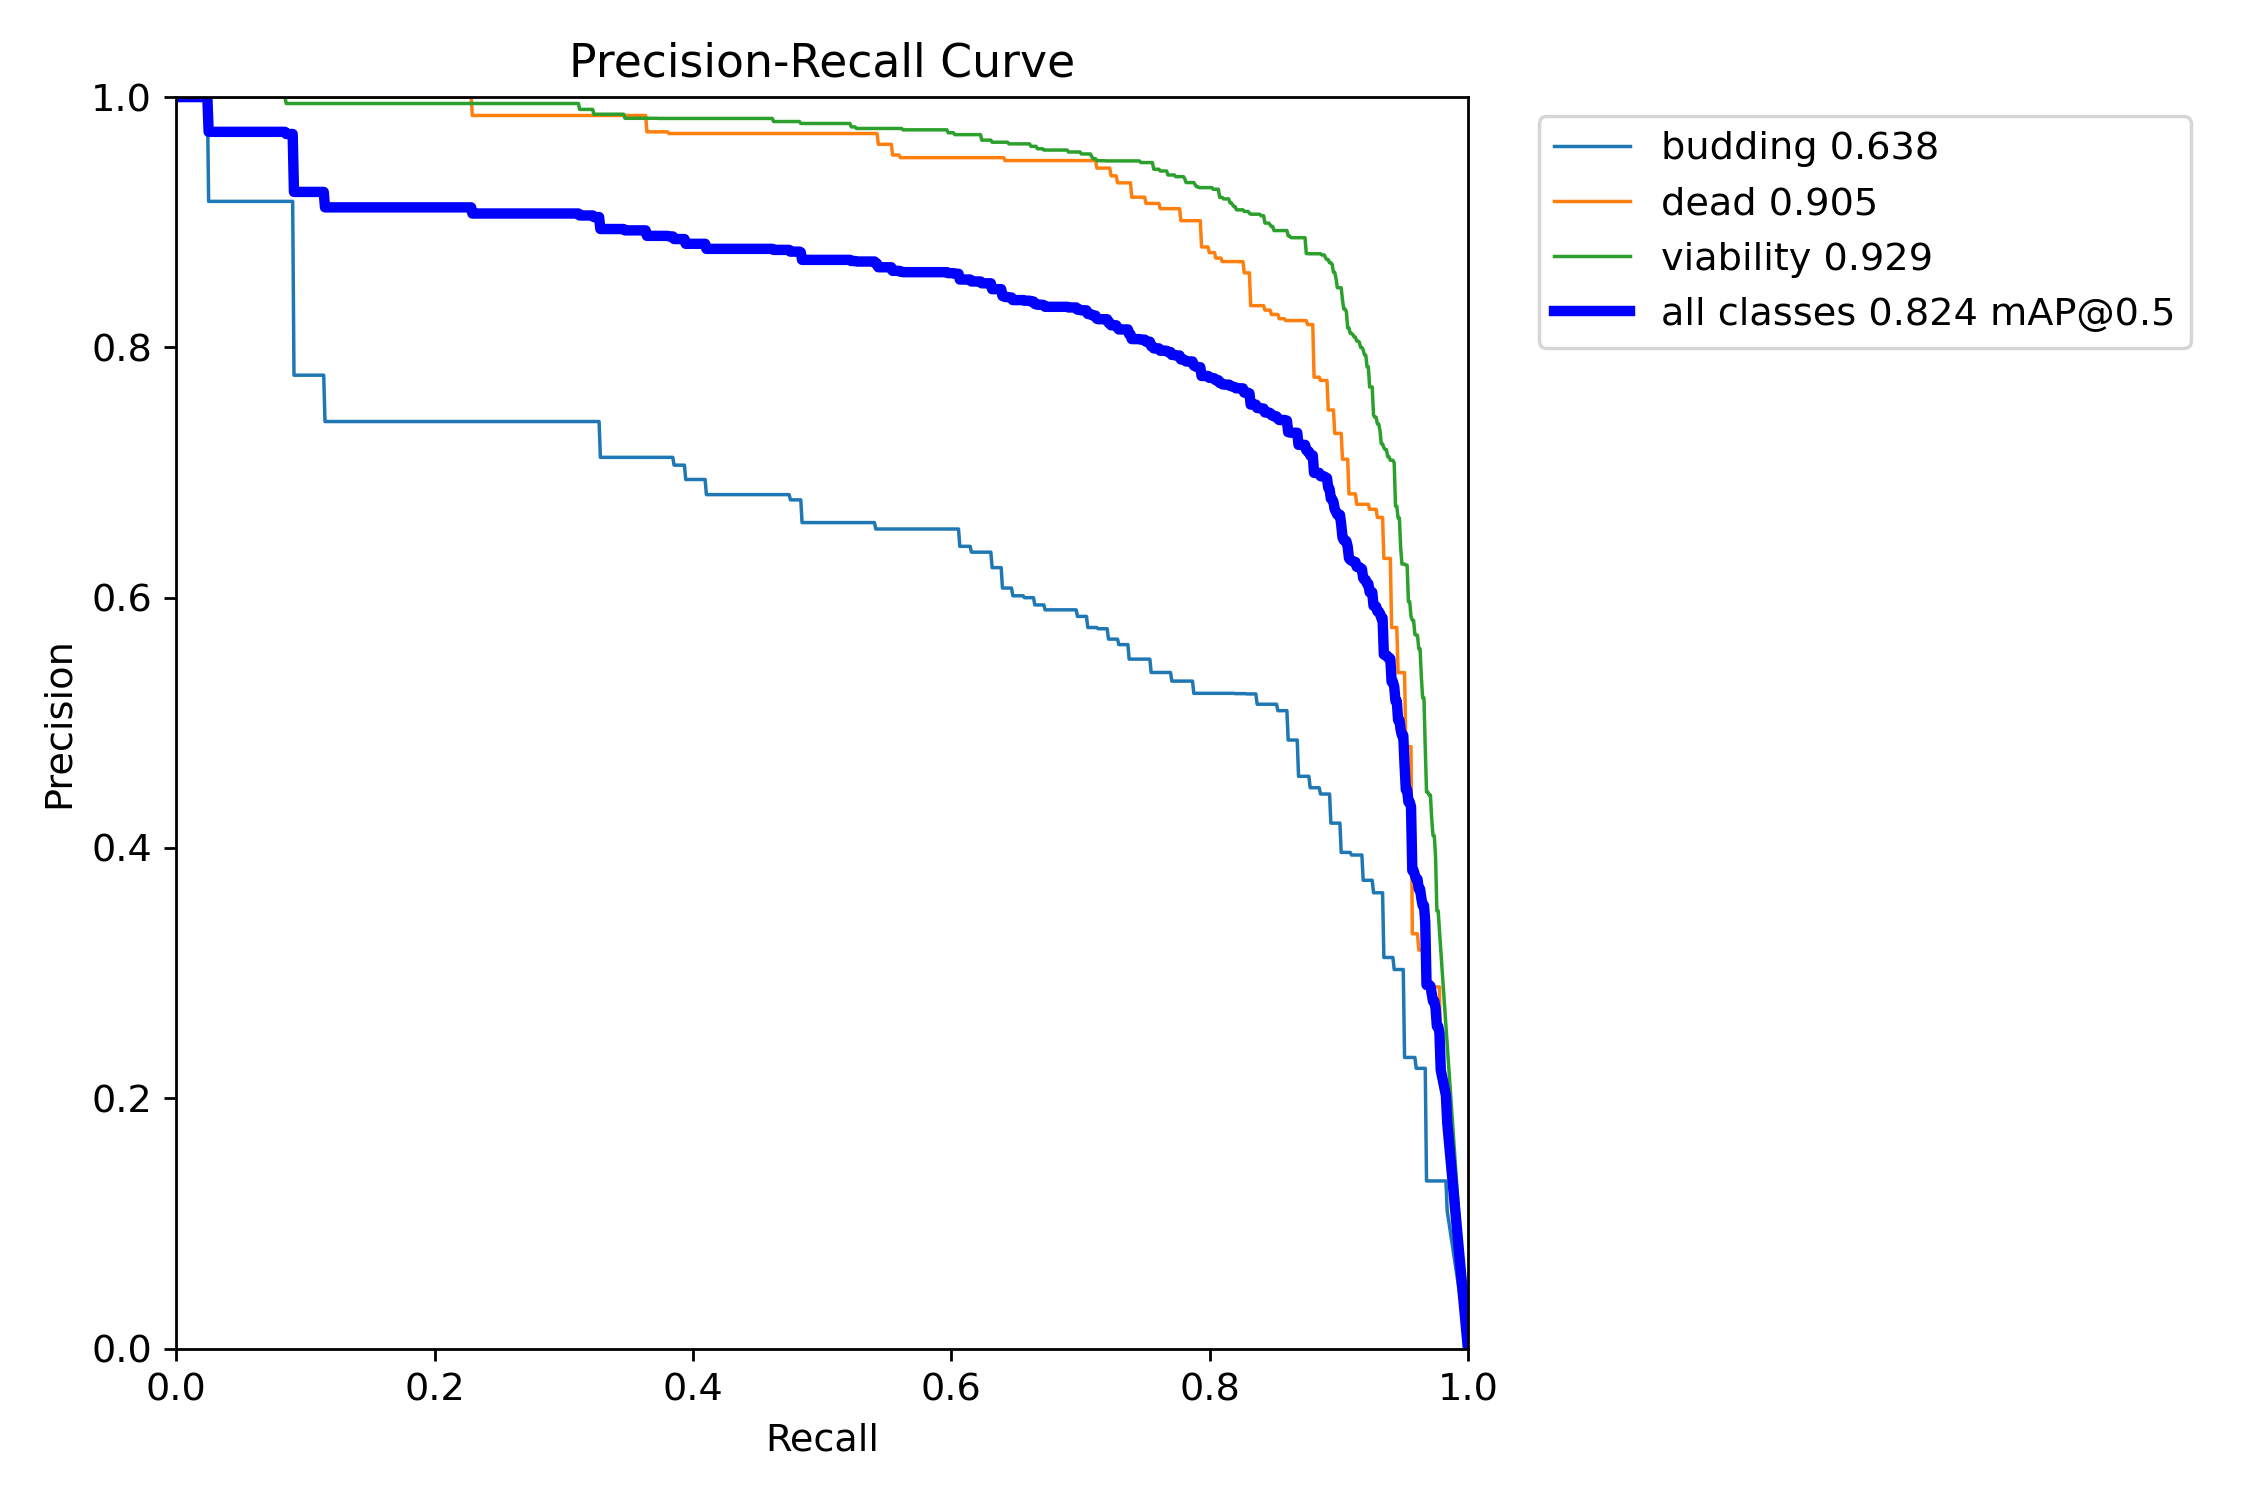

In [ ]:
folder = "runs/detect/train"
files = os.listdir(folder)
files = [x for x in files if x.endswith("png") or x.endswith("jpg")]
for file in files:
    path = os.path.join(folder, file)
    print(file)
    display(Image(path, width=300))

## モデルの性能評価

In [12]:
!mv datasets/yeast-deadcell-19/test datasets/test
!yolo task=detect mode=val　\
    data=data.yaml split=test \
        model="runs/detect/train/weights/best.pt"

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/test/labels... 10 images, 0 backgrounds, 0 corrupt: 100% 10/10 [00:00<00:00, 291.07it/s]
val: New cache created: /content/datasets/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:01<00:00,  1.10s/it]
                   all         10        753       0.71      0.856      0.778      0.468
               budding         10         97      0.568      0.794      0.569      0.336
                  dead         10        135       0.79      0.889      0.866      0.534
             viability         10        521      0.773      0.887        0.9      0.534
Speed: 0.5ms preprocess, 27.4ms inference, 0.0ms loss, 61.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val

## コマンドで推論

モデルを読み込みます。

In [16]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
model.info()

Model summary: 225 layers, 11136761 parameters, 0 gradients, 28.7 GFLOPs


(225, 11136761, 0, 28.651263999999998)

In [17]:
results = model('/content/datasets/test/images/3_MCE_png_jpg.rf.f212a5e3fead53268285c5c09825d563.jpg')


image 1/1 /content/datasets/test/images/3_MCE_png_jpg.rf.f212a5e3fead53268285c5c09825d563.jpg: 640x640 13 buddings, 3 deads, 51 viabilitys, 44.3ms
Speed: 5.0ms preprocess, 44.3ms inference, 871.5ms postprocess per image at shape (1, 3, 640, 640)


推論結果はpytorchなどの推論の戻値などと異なり、ultralytics.engine.results.Resultsです。また、今回は１枚の推論であるため、for loopで取り出せるのは１ループ分のみです。

(array([          0,           1,           2], dtype=float32), array([13,  3, 51]))


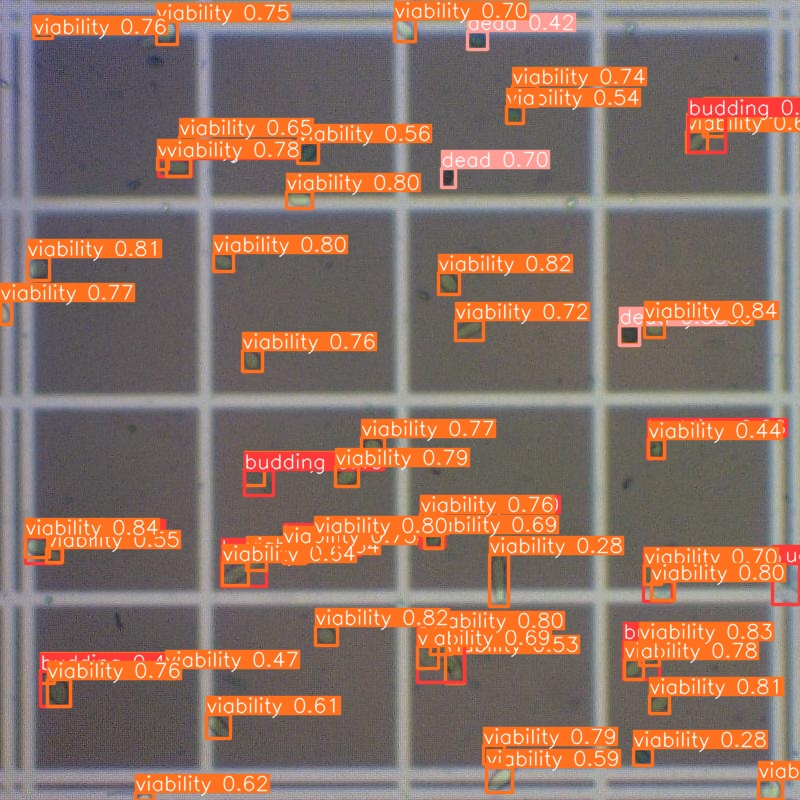

In [46]:
for i, result in enumerate(results):
    boxes = result.boxes
    # object label
    # print(boxes.cls.cpu().numpy())
    # count unique objects
    print(np.unique(boxes.cls.cpu().numpy(),
                    return_counts=True))
    # object confidence
    # print(boxes.conf.cpu().numpy())
    # object bbox coordinate
    # print(boxes.xywh.cpu().numpy())
    # save result image to disk
    path = f"{i}.jpg"
    result.save(path)
    # show image
    display(Image(path, width=300))